# Hull Tactical: Alpha Transformer + Dynamic Take Profit Strategy

## Architecture upgrade
- **model**: Alpha Transformer ( LGBM return)
- **strategy**: take profit + stop loss + position
- **time decay**: Sigmoid weights (2018 breakpoint，old regimesmooth transition)

## Transformer feature preprocessing
1. features: Top 50-100 features
2. normalization: StandardScaler (save Scaler)
3. serialization: [Batch, 30, Features] 3D

## Time-decay weighting scheme
- **Sigmoid weights**: 2007-2017 old regime (weights)，2018-2025 new regime (weights)
- **breakpoint**: 2018  ()
- **smooth transition**: 2017-2019 weights

## Strategy logic
- **take profit**: return > 5% →  50%
- **take profit**:  > 10 return →
- ****: Alpha  0.8  0.1 →  50%
- **stop loss**:  > 3% →

---

## 1. Environment setup

In [ ]:
!pip install optuna

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
from tqdm.auto import tqdm

!pip install optuna # Install optuna

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.style.use('seaborn-v0_8-whitegrid')

# Device configuration - Force CUDA on Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')

# GPU check
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
    #  GPU
    _ = torch.zeros(1).cuda()
else:
    print('WARNING: CUDA not available! Training will be slow.')
    print(' Colab  GPU:')
    print('  Runtime -> Change runtime type -> Hardware accelerator: GPU')

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ========== Colab  ==========
BASE_PATH = '../content/drive/MyDrive/hull'
DATA_PATH = f'{BASE_PATH}/data'
MODEL_PATH = f'{BASE_PATH}/models'
ANALYSIS_PATH = f'{BASE_PATH}/analysis'

print(f'BASE_PATH: {BASE_PATH}')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 27.8 MB/s eta 0:00:00
Using device: cuda
PyTorch version: 2.9.0+cu126
GPU: Tesla T4
GPU Memory: 15.8 GB
BASE_PATH: ../content/drive/MyDrive/hull


## 2. Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ========== load Transformer features ==========
DATA_PATH = '../content/drive/MyDrive/hull/data/'

# load Transformer /
df_train = pd.read_csv(DATA_PATH + 'transformer/train_transformer.csv')
df_val = pd.read_csv(DATA_PATH + 'transformer/val_transformer.csv')

# loadfeatures
with open('../content/drive/MyDrive/hull/models/transformer_features.json', 'r') as f:
    transformer_config = json.load(f)

transformer_features = transformer_config['selected_features']

print(f'train set: {df_train.shape}')
print(f'validation set: {df_val.shape}')
print(f'Transformer features: {len(transformer_features)}')
print(f'\nTop 10 features:')
for i, f in enumerate(transformer_features[:10], 1):
    print(f'  {i}. {f}')

train set: (3680, 69)
validation set: (901, 69)
Transformer features: 64

Top 10 features:
  1. E12_level
  2. V13_level
  3. M18_std_10d
  4. S5_level
  5. E17_diff_10d
  6. P8_std_10d
  7. E19_std_10d
  8. E12_roc_10d
  9. V2_std_20d
  10. S2_level


## 3. Target construction

In [ ]:
# ========== targetfeatures ==========
# target_alpha  train_transformer.csv / val_transformer.csv

print('target:')
print(f"train set target_alpha: mean={df_train['target_alpha'].mean():.6f}, std={df_train['target_alpha'].std():.6f}")
print(f"validation set target_alpha: mean={df_val['target_alpha'].mean():.6f}, std={df_val['target_alpha'].std():.6f}")

target:
train set target_alpha: mean=0.000764, std=0.023305
validation set target_alpha: mean=0.000104, std=0.022754


## 4. Transformer-specific feature preprocessing

### 4.1 features (Top 50-100)

In [ ]:
# ========== Transformer features ==========
SEQ_LEN = 10  # simplified: 30->10, features  #  (30)
N_TRANSFORMER_FEATURES = len(transformer_features)

print(f'Transformer features: {N_TRANSFORMER_FEATURES}')
print(f': {SEQ_LEN} ')

# features
types = transformer_config.get('feature_types', {})
if types:
    print(f'\nfeatures:')
    for k, v in types.items():
        print(f'  {k}: {v}')

Transformer features: 64
: 10 

features:
  level: 15
  roc: 14
  diff: 14
  std: 21


### 4.2 normalization (StandardScaler)

In [ ]:
# ==========  (features) ==========

print(f'train set: {len(df_train)} ')
print(f'validation set: {len(df_val)} ')

# ========== Alpha standardization (train set) ==========
target_alpha_mean = df_train['target_alpha'].mean()
target_alpha_std = df_train['target_alpha'].std()

alpha_normalization = {
    'mean': float(target_alpha_mean),
    'std': float(target_alpha_std)
}

# save
df_train['target_alpha_raw'] = df_train['target_alpha'].copy()
df_val['target_alpha_raw'] = df_val['target_alpha'].copy()

# standardization
df_train['target_alpha'] = (df_train['target_alpha'] - target_alpha_mean) / target_alpha_std
df_val['target_alpha'] = (df_val['target_alpha'] - target_alpha_mean) / target_alpha_std

# Clip
CLIP_SIGMA = 5.0
df_train['target_alpha'] = df_train['target_alpha'].clip(-CLIP_SIGMA, CLIP_SIGMA)
df_val['target_alpha'] = df_val['target_alpha'].clip(-CLIP_SIGMA, CLIP_SIGMA)

print(f'\nAlpha standardization')
print(f'standardization: mean={target_alpha_mean:.6f}, std={target_alpha_std:.6f}')

train set: 3680 
validation set: 901 

Alpha standardization
standardization: mean=0.000764, std=0.023305


In [ ]:
# ========== load Scaler (features) ==========
import os

with open('../content/drive/MyDrive/hull/models/transformer_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f'Scaler load: ../content/drive/MyDrive/hull/models/transformer_scaler.pkl')
print(f'  features: {len(transformer_features)}')

# featuresfeaturesstandardization，standardization
# featuresstandardization
sample_feat = transformer_features[0]
print(f'\n ({sample_feat}):')
print(f'  train set mean: {df_train[sample_feat].mean():.4f}, std: {df_train[sample_feat].std():.4f}')

Scaler load: ../content/drive/MyDrive/hull/models/transformer_scaler.pkl
  features: 64

 (E12_level):
  train set mean: -0.0000, std: 1.0001


### 4.3 serialization (3D Tensor: [Batch, Seq, Features])

In [ ]:
# ========== Sigmoid time decayweights + TimeSeriesDataset ==========

def compute_sigmoid_weights(dates, breakpoint_year=2018, steepness=2.0, min_weight=0.3, max_weight=1.0):
    """
     Sigmoid time decayweights
    - 2007-2017: weights min_weight
    - 2018-2025: weights max_weight

    dates: date_id  ()
    breakpoint_year: weightsbreakpoint
    """
    dates = np.array(dates)

    #
    # date_id
    #  2007 ，252 /
    date_min, date_max = dates.min(), dates.max()
    total_days = date_max - date_min + 1

    #
    #  date_id  (>2000)， date_id
    # ， reset
    if date_max > 2000:
        #  date_id:
        years = 2007 + dates / 252
    else:
        # ，
        #  2007-2025 ( 4600 )
        #
        normalized = (dates - date_min) / max(total_days, 1)
        years = 2007 + normalized * 18  # 18

    #  Sigmoid weights
    x = steepness * (years - breakpoint_year)
    sigmoid_val = 1 / (1 + np.exp(-x))

    #  [min_weight, max_weight]
    weights = min_weight + (max_weight - min_weight) * sigmoid_val

    return weights


class TimeSeriesDataset(Dataset):
    """
    time-series: [Batch, Seq, Features]
     Sigmoid time decay
    """
    def __init__(self, df, features, target_col, scaler, seq_len=30,
                 use_time_weights=True, breakpoint_year=2018,
                 steepness=2.0, min_weight=0.3, max_weight=1.0):
        self.seq_len = seq_len
        self.features = features
        self.use_time_weights = use_time_weights

        X = df[features].values
        y = df[target_col].values
        X_scaled = scaler.transform(X)

        # ==========  Sigmoid time decayweights ==========
        if use_time_weights:
            if 'date_id' in df.columns:
                date_ids = df['date_id'].values
            else:
                #
                date_ids = np.arange(len(df))

            all_weights = compute_sigmoid_weights(
                date_ids,
                breakpoint_year=breakpoint_year,
                steepness=steepness,
                min_weight=min_weight,
                max_weight=max_weight
            )

            # weights ()
            w_min, w_max, w_mean = all_weights.min(), all_weights.max(), all_weights.mean()
            if abs(w_max - w_min) > 0.01:
                print(f"  Sigmoid weights: min={w_min:.3f}, max={w_max:.3f}, mean={w_mean:.3f}")
        else:
            all_weights = np.ones(len(df))

        #
        self.sequences = []
        self.targets = []
        self.weights = []

        for i in range(seq_len, len(X_scaled)):
            self.sequences.append(X_scaled[i-seq_len:i])
            self.targets.append(y[i])
            self.weights.append(all_weights[i])

        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)
        self.weights = np.array(self.weights, dtype=np.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
            torch.tensor(self.weights[idx], dtype=torch.float32)
        )


# ========== time decayweights ==========
TIME_WEIGHT_CONFIG = {
    'breakpoint_year': 2018,
    'steepness': 2.0,
    'min_weight': 0.3,
    'max_weight': 1.0
}

print("=" * 60)
print(" (Sigmoid time decay)")
print("=" * 60)

# check date_id
if 'date_id' in df_train.columns:
    print(f"\ndate_id : {df_train['date_id'].min()} - {df_train['date_id'].max()}")
else:
    print("\nWARNING:  date_id ，")

#
print("\ntrain set:")
train_dataset = TimeSeriesDataset(
    df_train, transformer_features, 'target_alpha', scaler, SEQ_LEN,
    use_time_weights=True, **TIME_WEIGHT_CONFIG
)

#  ()
print("\nvalidation set:")
val_dataset = TimeSeriesDataset(
    df_val, transformer_features, 'target_alpha', scaler, SEQ_LEN,
    use_time_weights=False
)

print(f'\n: {len(train_dataset)}, : {len(val_dataset)}')
print(f': [Batch, {SEQ_LEN}, {N_TRANSFORMER_FEATURES}]')
print(f'train setweights: min={train_dataset.weights.min():.3f}, max={train_dataset.weights.max():.3f}, mean={train_dataset.weights.mean():.3f}')

 (Sigmoid time decay)

date_id : 20 - 3699

train set:
  Sigmoid weights: min=0.300, max=1.000, mean=0.476

validation set:

: 3670, : 891
: [Batch, 10, 64]
train setweights: min=0.300, max=1.000, mean=0.477


## 5. Alpha Transformer model definition

In [ ]:
class PositionalEncoding(nn.Module):
    """"""
    def __init__(self, d_model, max_len=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class AlphaTransformer(nn.Module):
    """
    Alpha Transformer: return Transformer model

    :
    - : [features] -> [d_model]
    -
    - Transformer Encoder ()
    -
    -
    """
    def __init__(
        self,
        n_features,
        d_model=64,
        n_heads=4,
        n_layers=2,
        d_ff=128,
        dropout=0.1,
        max_len=100
    ):
        super().__init__()

        self.n_features = n_features
        self.d_model = d_model

        #
        self.input_projection = nn.Linear(n_features, d_model)

        #
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        #
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

        #
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """
        x: [batch, seq_len, n_features]
        return: [batch, 1] (alpha prediction)
        """
        # : [batch, seq, features] -> [batch, seq, d_model]
        x = self.input_projection(x)

        #
        x = self.pos_encoder(x)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # : [batch, seq, d_model] -> [batch, d_model]
        x = x.mean(dim=1)

        #
        out = self.fc(x)

        return out.squeeze(-1)

# model
MODEL_CONFIG = {
    'n_features': N_TRANSFORMER_FEATURES,
    'd_model': 32,  # simplified
    'n_heads': 2,  # simplified
    'n_layers': 1,  # simplified: Transformer
    'd_ff': 64,  # simplified
    'dropout': 0.1,
    'max_len': SEQ_LEN + 10
}

#  (model Optuna optimize)
print(f'model: {MODEL_CONFIG}')
print(f'modelhyperparametersoptimize')

model: {'n_features': 64, 'd_model': 32, 'n_heads': 2, 'n_layers': 1, 'd_ff': 64, 'dropout': 0.1, 'max_len': 20}
modelhyperparametersoptimize


## 6. Transformer training

In [ ]:
# ========== IC Loss + time-seriescross-validation ==========

def ic_loss(pred, target, weights=None):
    """
    Information Coefficient Loss:
    IC = Pearson correlation between pred and target
    Loss = -IC ( loss)
    """
    pred = pred.squeeze()
    target = target.squeeze()

    #
    pred_centered = pred - pred.mean()
    target_centered = target - target.mean()

    #
    cov = (pred_centered * target_centered).mean()
    pred_std = pred_centered.std() + 1e-8
    target_std = target_centered.std() + 1e-8

    ic = cov / (pred_std * target_std)

    # weights， IC
    if weights is not None:
        weights = weights.squeeze()
        w_sum = weights.sum() + 1e-8
        pred_wmean = (pred * weights).sum() / w_sum
        target_wmean = (target * weights).sum() / w_sum

        pred_wcentered = pred - pred_wmean
        target_wcentered = target - target_wmean

        wcov = (weights * pred_wcentered * target_wcentered).sum() / w_sum
        pred_wstd = torch.sqrt((weights * pred_wcentered**2).sum() / w_sum) + 1e-8
        target_wstd = torch.sqrt((weights * target_wcentered**2).sum() / w_sum) + 1e-8

        ic = wcov / (pred_wstd * target_wstd)

    return -ic  #  IC  loss

def calc_ic(pred, target):
    """ IC (numpy )"""
    if len(pred) < 2:
        return 0.0
    return np.corrcoef(pred.flatten(), target.flatten())[0, 1]

def time_series_cv_splits(n_samples, n_splits=5, embargo=20):
    """time-seriescross-validation ()"""
    min_train_size = n_samples // (n_splits + 1)
    fold_size = (n_samples - min_train_size) // n_splits

    splits = []
    for i in range(n_splits):
        train_end = min_train_size + i * fold_size
        val_start = train_end + embargo
        val_end = min(train_end + fold_size, n_samples)

        if val_start < val_end:
            splits.append((list(range(train_end)), list(range(val_start, val_end))))

    return splits

def train_transformer_cv(
    df_train_full, transformer_features, target_col,
    model_config, scaler, device,
    n_splits=5, embargo=20, epochs=50, lr=1e-3, batch_size=64,
    patience=10, use_ic_loss=True
):
    """
    time-seriescross-validation Transformer
    : model,  IC,
    """
    from torch.utils.data import DataLoader

    n_samples = len(df_train_full)
    splits = time_series_cv_splits(n_samples, n_splits, embargo)

    print(f"time-seriescross-validation: {len(splits)} ")

    fold_ics = []
    best_overall_ic = -float('inf')
    best_model_state = None
    all_histories = []

    for fold_idx, (train_idx, val_idx) in enumerate(splits):
        print(f"\n--- Fold {fold_idx + 1}/{len(splits)} ---")
        print(f"Train: {len(train_idx)}, Val: {len(val_idx)}")

        #
        df_fold_train = df_train_full.iloc[train_idx].reset_index(drop=True)
        df_fold_val = df_train_full.iloc[val_idx].reset_index(drop=True)

        train_dataset = TimeSeriesDataset(df_fold_train, transformer_features, target_col, scaler, SEQ_LEN)
        val_dataset = TimeSeriesDataset(df_fold_val, transformer_features, target_col, scaler, SEQ_LEN)

        if len(train_dataset) < 10 or len(val_dataset) < 10:
            print(f"  skip: ")
            continue

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # model
        model = AlphaTransformer(**model_config).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        best_fold_ic = -float('inf')
        best_fold_state = None
        patience_counter = 0

        for epoch in range(epochs):
            #
            model.train()
            train_losses = []
            for X_batch, y_batch, w_batch in train_loader:
                X_batch, y_batch, w_batch = X_batch.to(device), y_batch.to(device), w_batch.to(device)

                optimizer.zero_grad()
                pred = model(X_batch)

                if use_ic_loss:
                    loss = ic_loss(pred, y_batch, w_batch)
                else:
                    loss = weighted_huber_loss(pred, y_batch, w_batch, delta=0.01)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_losses.append(loss.item())

            scheduler.step()

            #
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for X_batch, y_batch, _ in val_loader:
                    X_batch = X_batch.to(device)
                    pred = model(X_batch)
                    val_preds.extend(pred.cpu().numpy())
                    val_targets.extend(y_batch.numpy())

            val_ic = calc_ic(np.array(val_preds), np.array(val_targets))

            if val_ic > best_fold_ic:
                best_fold_ic = val_ic
                best_fold_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        print(f"  Fold {fold_idx + 1} Best IC: {best_fold_ic:.4f}")
        fold_ics.append(best_fold_ic)

        if best_fold_ic > best_overall_ic:
            best_overall_ic = best_fold_ic
            best_model_state = best_fold_state

    avg_ic = np.mean(fold_ics) if fold_ics else 0.0
    print(f"\n IC: {avg_ic:.4f} (±{np.std(fold_ics):.4f})")

    # loadmodel
    final_model = AlphaTransformer(**model_config).to(device)
    if best_model_state:
        final_model.load_state_dict(best_model_state)

    return final_model, avg_ic, {'fold_ics': fold_ics, 'avg_ic': avg_ic}

print("✓ IC Loss time-seriescross-validation")

✓ IC Loss time-seriescross-validation


In [ ]:
# ========== Optuna hyperparametersoptimize: Alpha Transformer (fast version) ==========
RUN_TRANSFORMER_HYPEROPT = True
N_TRANSFORMER_TRIALS = 30  #

def create_transformer_cv_objective(df_train_full, transformer_features, target_col, scaler, device, n_splits=3, n_epochs=15):
    """fast version: 3CV, 15 epochs, """

    def objective(trial):
        config = {
            'n_features': len(transformer_features),
            'd_model': trial.suggest_categorical('d_model', [16, 32]),  # simplified,
            'n_heads': trial.suggest_categorical('n_heads', [1, 2]),  # simplified,
            'n_layers': trial.suggest_int('n_layers', 1, 2),  # simplified: 2,
            'd_ff': trial.suggest_categorical('d_ff', [32, 64]),  # simplified,
            'dropout': trial.suggest_float('dropout', 0.1, 0.3),
            'max_len': SEQ_LEN + 10
        }

        if config['d_model'] % config['n_heads'] != 0:
            return float('-inf')

        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])  # larger batch
        weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-1, log=True)

        splits = time_series_cv_splits(len(df_train_full), n_splits=n_splits, embargo=20)
        fold_ics = []

        for train_idx, val_idx in splits:
            df_fold_train = df_train_full.iloc[train_idx].reset_index(drop=True)
            df_fold_val = df_train_full.iloc[val_idx].reset_index(drop=True)

            train_dataset = TimeSeriesDataset(df_fold_train, transformer_features, target_col, scaler, SEQ_LEN)
            val_dataset = TimeSeriesDataset(df_fold_val, transformer_features, target_col, scaler, SEQ_LEN)

            if len(train_dataset) < 10 or len(val_dataset) < 10:
                continue

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

            model = AlphaTransformer(**config).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

            best_ic = -float('inf')
            patience_counter = 0

            for epoch in range(n_epochs):
                model.train()
                for X_batch, y_batch, w_batch in train_loader:
                    X_batch = X_batch.to(device, non_blocking=True)
                    y_batch = y_batch.to(device, non_blocking=True)
                    w_batch = w_batch.to(device, non_blocking=True)

                    optimizer.zero_grad(set_to_none=True)  #
                    pred = model(X_batch)
                    loss = ic_loss(pred, y_batch, w_batch)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                #
                model.eval()
                val_preds, val_targets = [], []
                with torch.no_grad():
                    for X_batch, y_batch, _ in val_loader:
                        pred = model(X_batch.to(device, non_blocking=True))
                        val_preds.extend(pred.cpu().numpy())
                        val_targets.extend(y_batch.numpy())

                val_ic = calc_ic(np.array(val_preds), np.array(val_targets))

                if val_ic > best_ic:
                    best_ic = val_ic
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= 3:  #
                    break

            fold_ics.append(best_ic)

            # Pruning: ，skip
            if len(fold_ics) == 1 and best_ic < -0.1:
                return float('-inf')

        return np.mean(fold_ics) if fold_ics else float('-inf')

    return objective

if RUN_TRANSFORMER_HYPEROPT:
    print(f'Training on device: {device}')
    if device.type == 'cuda':
        print(f'GPU: {torch.cuda.get_device_name(0)}')
        torch.backends.cudnn.benchmark = True  #  cuDNN optimize
    print('=' * 60)
    print('Optuna hyperparametersoptimize: Transformer (fast version: 3CV, 15epochs)')
    print('=' * 60)

    df_transformer_full = pd.concat([df_train, df_val], ignore_index=True)

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(
        create_transformer_cv_objective(df_transformer_full, transformer_features, 'target_alpha', scaler, device),
        n_trials=N_TRANSFORMER_TRIALS,
        show_progress_bar=True,
        gc_after_trial=True  #
    )

    print(f'\nBest IC: {study.best_value:.4f}')
    print(f'Best params: {study.best_params}')

    MODEL_CONFIG_OPTIMIZED = {
        'n_features': len(transformer_features),
        'd_model': study.best_params['d_model'],
        'n_heads': study.best_params['n_heads'],
        'n_layers': study.best_params['n_layers'],
        'd_ff': study.best_params['d_ff'],
        'dropout': study.best_params['dropout'],
        'max_len': SEQ_LEN + 10
    }
    LR_OPTIMIZED = study.best_params['lr']
    BATCH_SIZE_OPTIMIZED = study.best_params['batch_size']
    WEIGHT_DECAY_OPTIMIZED = study.best_params['weight_decay']
else:
    MODEL_CONFIG_OPTIMIZED = {
        'n_features': len(transformer_features),
        'd_model': 64, 'n_heads': 4, 'n_layers': 2,
        'd_ff': 128, 'dropout': 0.1, 'max_len': SEQ_LEN + 10
    }
    LR_OPTIMIZED = 1e-3
    BATCH_SIZE_OPTIMIZED = 64
    WEIGHT_DECAY_OPTIMIZED = 0.01

print(f'\noptimize: {MODEL_CONFIG_OPTIMIZED}')

Training on device: cuda
GPU: Tesla T4
Optuna hyperparametersoptimize: Transformer (fast version: 3CV, 15epochs)


  0%|          | 0/30 [00:00<?, ?it/s]

  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Sigmoid weights: min=0.300, max=0.317, mean=0.302
  Sigmoid weights: min=0.300, max=0.317, mean=0.301
  Sigmoid weights: min=0.320, max=0.997, mean=0.723
  Sigmoid weights: min=0.300, max=0.997, mean=0.439
  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Sigmoid weights: min=0.300, max=0.317, mean=0.302
  Sigmoid weights: min=0.300, max=0.317, mean=0.301
  Sigmoid weights: min=0.320, max=0.997, mean=0.723
  Sigmoid weights: min=0.300, max=0.997, mean=0.439
  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Sigmoid weights: min=0.300, max=0.317, mean=0.302
  Sigmoid weights: min=0.300, max=0.317, mean=0.301
  Sigmoid weights: min=0.320, max=0.997, mean=0.723
  Sigmoid weights: min=0.300, max=0.997, mean=0.439
  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Sigmoid weights: min=0.300, max=0.317, mean=0.302
  Sigmoid weights: min=0.300, max=0.317, mean=0.301
  Sigmoid weights: min=0.320, max=0.997, mean=0.723
  Sigmoid we

In [ ]:
# ==========  5 time-series CV  Transformer ==========
EPOCHS = 100
PATIENCE = 15
N_CV_FOLDS = 5

print('=' * 60)
print(' Alpha Transformer (5time-seriesCV + IC Loss + time decay)')
print('=' * 60)

#  CV
df_transformer_full = pd.concat([df_train, df_val], ignore_index=True)

# time-series CV
model, avg_ic, cv_history = train_transformer_cv(
    df_transformer_full, transformer_features, 'target_alpha',
    MODEL_CONFIG_OPTIMIZED, scaler, device,
    n_splits=N_CV_FOLDS, embargo=20,
    epochs=EPOCHS, lr=LR_OPTIMIZED, batch_size=BATCH_SIZE_OPTIMIZED,
    patience=PATIENCE, use_ic_loss=True
)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTransformer : {n_params:,}')
print(f'5 IC: {avg_ic:.4f}')
print(f' IC: {cv_history["fold_ics"]}')

# save
history = cv_history

 Alpha Transformer (5time-seriesCV + IC Loss + time decay)
time-seriescross-validation: 5 

--- Fold 1/5 ---
Train: 763, Val: 743
  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Fold 1 Best IC: 0.0191

--- Fold 2/5 ---
Train: 1526, Val: 743
  Sigmoid weights: min=0.300, max=1.000, mean=0.572
  Sigmoid weights: min=0.300, max=0.317, mean=0.303
  Fold 2 Best IC: 0.0843

--- Fold 3/5 ---
Train: 2289, Val: 743
  Sigmoid weights: min=0.300, max=0.317, mean=0.301
  Sigmoid weights: min=0.320, max=0.940, mean=0.589
  Fold 3 Best IC: 0.0947

--- Fold 4/5 ---
Train: 3052, Val: 743
  Sigmoid weights: min=0.300, max=0.940, mean=0.371
  Sigmoid weights: min=0.949, max=1.000, mean=0.991
  Fold 4 Best IC: 0.1790

--- Fold 5/5 ---
Train: 3815, Val: 743
  Sigmoid weights: min=0.300, max=1.000, mean=0.495
  Fold 5 Best IC: 0.1025

 IC: 0.0959 (±0.0510)

Transformer : 5,633
5 IC: 0.0959
 IC: [np.float64(0.019117716691838663), np.float64(0.0843199

In [ ]:
# ========== save Transformer model Scaler ==========
import os
os.makedirs(MODEL_PATH, exist_ok=True)

# save Transformer modelweights
torch.save(model.state_dict(), f'{MODEL_PATH}/alpha_transformer.pt')

# save Scaler
with open(f'{MODEL_PATH}/scaler_alpha.pkl', 'wb') as f:
    pickle.dump(scaler, f)

#  IC ( CV  CV )
if 'fold_ics' in history:
    best_ic = history['avg_ic']
    fold_ics = history['fold_ics']
elif 'val_ic' in history:
    best_ic = max(history['val_ic'])
    fold_ics = None
else:
    best_ic = avg_ic if 'avg_ic' in dir() else 0.0
    fold_ics = None

# savemodel
config_to_save = {
    'model_config': MODEL_CONFIG_OPTIMIZED,
    'lr': LR_OPTIMIZED,
    'batch_size': BATCH_SIZE_OPTIMIZED,
    'transformer_features': transformer_features,
    'seq_len': SEQ_LEN,
    'optuna_optimized': RUN_TRANSFORMER_HYPEROPT,
    'time_weight_config': TIME_WEIGHT_CONFIG,
    'best_val_ic': best_ic,
    'cv_fold_ics': fold_ics
}

#  alpha_normalization ()
if 'alpha_normalization' in dir():
    config_to_save['alpha_normalization'] = alpha_normalization

with open(f'{MODEL_PATH}/transformer_config.json', 'w') as f:
    json.dump(config_to_save, f, indent=2)

print('✓ Transformer modelsave')
print(f'  - {MODEL_PATH}/alpha_transformer.pt')
print(f'  - {MODEL_PATH}/scaler_alpha.pkl')
print(f'  - {MODEL_PATH}/transformer_config.json')
print(f'\nBest Val IC: {best_ic:.4f}')
if fold_ics:
    print(f'Fold ICs: {[f"{ic:.4f}" for ic in fold_ics]}')

✓ Transformer modelsave
  - ../content/drive/MyDrive/hull/models/alpha_transformer.pt
  - ../content/drive/MyDrive/hull/models/scaler_alpha.pkl
  - ../content/drive/MyDrive/hull/models/transformer_config.json

Best Val IC: 0.0959
Fold ICs: ['0.0191', '0.0843', '0.0947', '0.1790', '0.1025']


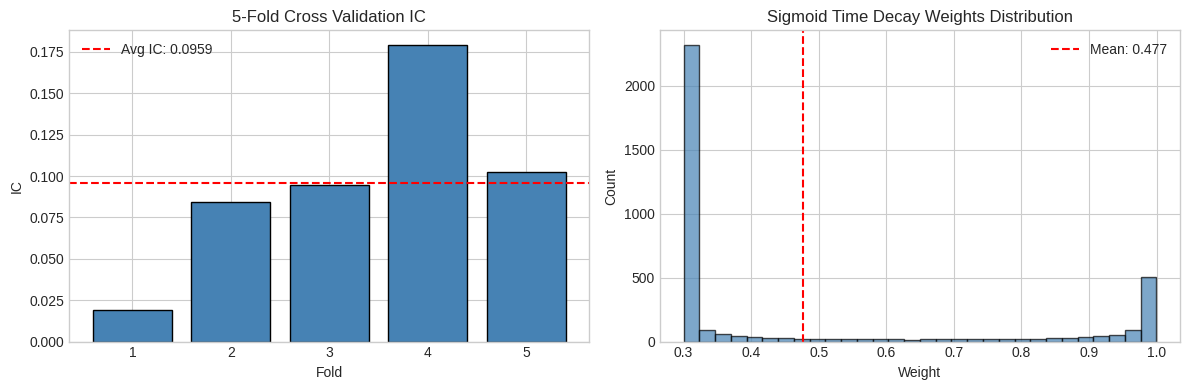


5-Fold CV Results:
  Fold 1: IC = 0.0191
  Fold 2: IC = 0.0843
  Fold 3: IC = 0.0947
  Fold 4: IC = 0.1790
  Fold 5: IC = 0.1025
  Average IC: 0.0959

time decayweights: min=0.300, max=1.000, mean=0.477


In [ ]:
# ==========  ==========
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# CV Fold ICs
if 'fold_ics' in history and history['fold_ics']:
    fold_ics = history['fold_ics']
    axes[0].bar(range(1, len(fold_ics)+1), fold_ics, color='steelblue', edgecolor='black')
    axes[0].axhline(y=history['avg_ic'], color='r', linestyle='--',
                    label=f'Avg IC: {history["avg_ic"]:.4f}')
    axes[0].set_title('5-Fold Cross Validation IC')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('IC')
    axes[0].set_xticks(range(1, len(fold_ics)+1))
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'No CV history available', ha='center', va='center')
    axes[0].set_title('CV Results')

# time decayweights
axes[1].hist(train_dataset.weights, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(x=train_dataset.weights.mean(), color='r', linestyle='--',
               label=f'Mean: {train_dataset.weights.mean():.3f}')
axes[1].set_title('Sigmoid Time Decay Weights Distribution')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

#
if 'fold_ics' in history:
    print(f'\n5-Fold CV Results:')
    for i, ic in enumerate(history['fold_ics'], 1):
        print(f'  Fold {i}: IC = {ic:.4f}')
    print(f'  Average IC: {history["avg_ic"]:.4f}')
print(f'\ntime decayweights: min={train_dataset.weights.min():.3f}, max={train_dataset.weights.max():.3f}, mean={train_dataset.weights.mean():.3f}')

## 7. Risk & Regime model (LightGBM)

Alpha  Transformer，Risk  Regime  LightGBM。

In [ ]:
# ========== loadmodel:  (2007-2025 + 2018-2025) ==========
# Long period: 2007-2025 (features)
df_tree_long = pd.read_csv(f'{DATA_PATH}/intermediate/train_no_missing_2007_2025_final.csv')

# Short period: 2018-2025 (features)
df_tree_short = pd.read_csv(f'{DATA_PATH}/intermediate/train_2018_2025_final.csv')

print(f'Long period (2007-2025): {len(df_tree_long)} ')
print(f'Short period (2018-2025): {len(df_tree_short)} ')

#
META_COLS = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# features
all_features_long = [col for col in df_tree_long.columns if col not in META_COLS]
all_features_short = [col for col in df_tree_short.columns if col not in META_COLS]

print(f'\nLong features: {len(all_features_long)}')
print(f'Short features: {len(all_features_short)}')

# Risk/Regime modelfeatures
risk_features_long = all_features_long.copy()
risk_features_short = all_features_short.copy()
regime_features_long = all_features_long.copy()
regime_features_short = all_features_short.copy()

# target
def add_targets(df):
    df = df.copy()
    returns = df['market_forward_excess_returns']
    df['target_alpha'] = returns.rolling(5).sum().shift(-4)
    df['target_risk'] = np.log(returns.rolling(5).std() * np.sqrt(252) + 1e-8).shift(-4)
    future_20d = returns.rolling(20).sum().shift(-19)
    df['target_regime'] = np.select([(future_20d < -0.03), (future_20d > 0.03)], [0, 2], default=1)
    return df

df_tree_long = add_targets(df_tree_long)
df_tree_short = add_targets(df_tree_short)

#  NaN
df_tree_long_clean = df_tree_long.dropna(subset=['target_alpha', 'target_risk', 'target_regime']).reset_index(drop=True)
df_tree_short_clean = df_tree_short.dropna(subset=['target_alpha', 'target_risk', 'target_regime']).reset_index(drop=True)

# Long: 80/20
EMBARGO = 20
train_end_long = int(len(df_tree_long_clean) * 0.8)
val_start_long = train_end_long + EMBARGO
df_train_long = df_tree_long_clean.iloc[:train_end_long].copy()
df_val_long = df_tree_long_clean.iloc[val_start_long:].copy()

# Short: 80/20
train_end_short = int(len(df_tree_short_clean) * 0.8)
val_start_short = train_end_short + EMBARGO
df_train_short = df_tree_short_clean.iloc[:train_end_short].copy()
df_val_short = df_tree_short_clean.iloc[val_start_short:].copy()

print(f'\nLong train set: {len(df_train_long)}, validation set: {len(df_val_long)}')
print(f'Short train set: {len(df_train_short)}, validation set: {len(df_val_short)}')

Long period (2007-2025): 4625 
Short period (2018-2025): 1872 

Long features: 147
Short features: 147

Long train set: 3696, validation set: 905
Short train set: 1494, validation set: 354


In [ ]:
# ========== Risk Model  ==========
risk_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.02,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'min_child_samples': 100,
    'reg_alpha': 0.2,
    'reg_lambda': 0.2,
    'verbose': -1,
    'random_state': 42
}

# ========== Regime Model  ==========
regime_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.02,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'min_child_samples': 100,
    'verbose': -1,
    'random_state': 42
}

def get_class_weights(y):
    """weights"""
    class_counts = np.bincount(y.astype(int), minlength=3)
    class_weights = len(y) / (3 * class_counts + 1e-8)
    return class_weights[y.astype(int)]

print('LGBM ')

LGBM 


In [ ]:
# ========== Optuna hyperparametersoptimize: LightGBM ( Risk & Regime) ==========
RUN_LGBM_HYPEROPT = True
N_LGBM_TRIALS = 30

EMBARGO_RISK = 5
EMBARGO_REGIME = 20

def time_series_cv_with_embargo(n_samples, n_splits=3, embargo=5):
    fold_size = n_samples // (n_splits + 1)
    for i in range(n_splits):
        train_end = fold_size * (i + 1)
        val_start = train_end + embargo
        val_end = min(val_start + fold_size, n_samples)
        if val_start < n_samples:
            yield np.arange(train_end), np.arange(val_start, val_end)

def create_risk_objective(X, y, features, n_splits=3, embargo=EMBARGO_RISK):
    def objective(trial):
        params = {
            'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 7, 63),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.9),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            'verbose': -1, 'random_state': 42
        }
        scores = []
        for train_idx, val_idx in time_series_cv_with_embargo(len(X), n_splits, embargo):
            train_data = lgb.Dataset(X[train_idx], label=y[train_idx], feature_name=features)
            val_data = lgb.Dataset(X[val_idx], label=y[val_idx], feature_name=features, reference=train_data)
            model = lgb.train(params, train_data, num_boost_round=300, valid_sets=[val_data],
                              callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)])
            pred = model.predict(X[val_idx])
            scores.append(np.sqrt(mean_squared_error(y[val_idx], pred)))
        return np.mean(scores) if scores else float('inf')
    return objective

def create_regime_objective(X, y, features, n_splits=3, embargo=EMBARGO_REGIME):
    from sklearn.metrics import log_loss
    def objective(trial):
        params = {
            'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss', 'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 7, 63),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.9),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
            'verbose': -1, 'random_state': 42
        }
        scores = []
        for train_idx, val_idx in time_series_cv_with_embargo(len(X), n_splits, embargo):
            class_counts = np.bincount(y[train_idx].astype(int), minlength=3)
            w_tr = (len(y[train_idx]) / (3 * class_counts + 1e-8))[y[train_idx].astype(int)]
            train_data = lgb.Dataset(X[train_idx], label=y[train_idx], weight=w_tr, feature_name=features)
            val_data = lgb.Dataset(X[val_idx], label=y[val_idx], feature_name=features, reference=train_data)
            model = lgb.train(params, train_data, num_boost_round=300, valid_sets=[val_data],
                              callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)])
            scores.append(log_loss(y[val_idx], model.predict(X[val_idx])))
        return np.mean(scores) if scores else float('inf')
    return objective

def get_class_weights(y):
    class_counts = np.bincount(y.astype(int), minlength=3)
    return (len(y) / (3 * class_counts + 1e-8))[y.astype(int)]

if RUN_LGBM_HYPEROPT:
    print('=' * 60)
    print('Optuna hyperparametersoptimize: LightGBM ( Risk & Regime)')
    print('=' * 60)

    # ========== Long Risk ==========
    print('\n--- Long Risk Model ---')
    study_risk_long = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_risk_long.optimize(
        create_risk_objective(df_tree_long_clean[risk_features_long].values,
                              df_tree_long_clean['target_risk'].values, risk_features_long),
        n_trials=N_LGBM_TRIALS, show_progress_bar=True)
    print(f'Best RMSE: {study_risk_long.best_value:.4f}')

    # ========== Short Risk ==========
    print('\n--- Short Risk Model ---')
    study_risk_short = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_risk_short.optimize(
        create_risk_objective(df_tree_short_clean[risk_features_short].values,
                              df_tree_short_clean['target_risk'].values, risk_features_short),
        n_trials=N_LGBM_TRIALS, show_progress_bar=True)
    print(f'Best RMSE: {study_risk_short.best_value:.4f}')

    # ========== Long Regime ==========
    print('\n--- Long Regime Model ---')
    study_regime_long = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_regime_long.optimize(
        create_regime_objective(df_tree_long_clean[regime_features_long].values,
                                df_tree_long_clean['target_regime'].astype(int).values, regime_features_long),
        n_trials=N_LGBM_TRIALS, show_progress_bar=True)
    print(f'Best LogLoss: {study_regime_long.best_value:.4f}')

    # ========== Short Regime ==========
    print('\n--- Short Regime Model ---')
    study_regime_short = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_regime_short.optimize(
        create_regime_objective(df_tree_short_clean[regime_features_short].values,
                                df_tree_short_clean['target_regime'].astype(int).values, regime_features_short),
        n_trials=N_LGBM_TRIALS, show_progress_bar=True)
    print(f'Best LogLoss: {study_regime_short.best_value:.4f}')

    # save
    risk_params_long = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt',
                        'verbose': -1, 'random_state': 42, **study_risk_long.best_params}
    risk_params_short = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt',
                         'verbose': -1, 'random_state': 42, **study_risk_short.best_params}
    regime_params_long = {'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss',
                          'boosting_type': 'gbdt', 'verbose': -1, 'random_state': 42, **study_regime_long.best_params}
    regime_params_short = {'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss',
                           'boosting_type': 'gbdt', 'verbose': -1, 'random_state': 42, **study_regime_short.best_params}

    print('\n✓ LightGBM hyperparametersoptimize ()')
else:
    risk_params_long = risk_params_short = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt',
        'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_fraction': 0.8,
        'bagging_freq': 5, 'verbose': -1, 'random_state': 42}
    regime_params_long = regime_params_short = {'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss',
        'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.8,
        'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'random_state': 42}
    print('skip LightGBM hyperparametersoptimize，')

Optuna hyperparametersoptimize: LightGBM ( Risk & Regime)

--- Long Risk Model ---


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.541934
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.613732
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.493925
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.542627
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 0.60228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 0.473386
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 0.54224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 0.

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.616574
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.541702
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.423555
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[136]	valid_0's rmse: 0.632316
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 0.5444
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.450313
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 0.647701
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 0.

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.97341
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.879726
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.979452
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.973658
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.961008
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 1.04342
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.975072
Training until validation scores don't improve for 30 r

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 1.04447
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 1.04643
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's multi_logloss: 1.08046
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.04085
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 1.09137
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09891
Training until validation scores don't improve for 30 rounds
Early

In [ ]:
# ==========  Risk Model () ==========
print('=' * 60)
print(' Risk Model (LightGBM) - ')
print('=' * 60)

# ========== Long Risk ==========
print('\n--- Long Risk (2007-2025) ---')
X_risk_train_long = df_train_long[risk_features_long].values
y_risk_train_long = df_train_long['target_risk'].values
X_risk_val_long = df_val_long[risk_features_long].values
y_risk_val_long = df_val_long['target_risk'].values

train_data_risk_long = lgb.Dataset(X_risk_train_long, label=y_risk_train_long, feature_name=risk_features_long)
val_data_risk_long = lgb.Dataset(X_risk_val_long, label=y_risk_val_long, feature_name=risk_features_long, reference=train_data_risk_long)

risk_model_long = lgb.train(
    risk_params_long, train_data_risk_long, num_boost_round=500,
    valid_sets=[val_data_risk_long],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)
print(f'Risk Long best_iteration: {risk_model_long.best_iteration}')

# ========== Short Risk ==========
print('\n--- Short Risk (2018-2025) ---')
X_risk_train_short = df_train_short[risk_features_short].values
y_risk_train_short = df_train_short['target_risk'].values
X_risk_val_short = df_val_short[risk_features_short].values
y_risk_val_short = df_val_short['target_risk'].values

train_data_risk_short = lgb.Dataset(X_risk_train_short, label=y_risk_train_short, feature_name=risk_features_short)
val_data_risk_short = lgb.Dataset(X_risk_val_short, label=y_risk_val_short, feature_name=risk_features_short, reference=train_data_risk_short)

risk_model_short = lgb.train(
    risk_params_short, train_data_risk_short, num_boost_round=500,
    valid_sets=[val_data_risk_short],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)
print(f'Risk Short best_iteration: {risk_model_short.best_iteration}')

print('\n✓ Risk Model  ()')

 Risk Model (LightGBM) - 

--- Long Risk (2007-2025) ---
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.473337
Early stopping, best iteration is:
[42]	valid_0's rmse: 0.472139
Risk Long best_iteration: 42

--- Short Risk (2018-2025) ---
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.453317
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.448211
Risk Short best_iteration: 26

✓ Risk Model  ()


In [ ]:
# ==========  Regime Model () ==========
print('=' * 60)
print(' Regime Model (LightGBM) - ')
print('=' * 60)

# ========== Long Regime ==========
print('\n--- Long Regime (2007-2025) ---')
X_regime_train_long = df_train_long[regime_features_long].values
y_regime_train_long = df_train_long['target_regime'].astype(int).values
X_regime_val_long = df_val_long[regime_features_long].values
y_regime_val_long = df_val_long['target_regime'].astype(int).values

w_regime_train_long = get_class_weights(y_regime_train_long)
train_data_regime_long = lgb.Dataset(X_regime_train_long, label=y_regime_train_long,
                                     weight=w_regime_train_long, feature_name=regime_features_long)
val_data_regime_long = lgb.Dataset(X_regime_val_long, label=y_regime_val_long,
                                   feature_name=regime_features_long, reference=train_data_regime_long)

regime_model_long = lgb.train(
    regime_params_long, train_data_regime_long, num_boost_round=500,
    valid_sets=[val_data_regime_long],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)
print(f'Regime Long best_iteration: {regime_model_long.best_iteration}')

# ========== Short Regime ==========
print('\n--- Short Regime (2018-2025) ---')
X_regime_train_short = df_train_short[regime_features_short].values
y_regime_train_short = df_train_short['target_regime'].astype(int).values
X_regime_val_short = df_val_short[regime_features_short].values
y_regime_val_short = df_val_short['target_regime'].astype(int).values

w_regime_train_short = get_class_weights(y_regime_train_short)
train_data_regime_short = lgb.Dataset(X_regime_train_short, label=y_regime_train_short,
                                      weight=w_regime_train_short, feature_name=regime_features_short)
val_data_regime_short = lgb.Dataset(X_regime_val_short, label=y_regime_val_short,
                                    feature_name=regime_features_short, reference=train_data_regime_short)

regime_model_short = lgb.train(
    regime_params_short, train_data_regime_short, num_boost_round=500,
    valid_sets=[val_data_regime_short],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)
print(f'Regime Short best_iteration: {regime_model_short.best_iteration}')

print('\n✓ Regime Model  ()')

 Regime Model (LightGBM) - 

--- Long Regime (2007-2025) ---
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.974118
[100]	valid_0's multi_logloss: 0.976053
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.961069
Regime Long best_iteration: 81

--- Short Regime (2018-2025) ---
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.04578
[100]	valid_0's multi_logloss: 1.04833
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 1.02165
Regime Short best_iteration: 72

✓ Regime Model  ()


In [ ]:
# ========== save LGBM model () ==========
import os
os.makedirs('../models', exist_ok=True)

risk_model_long.save_model(f'{MODEL_PATH}/risk_model_long.txt')
risk_model_short.save_model(f'{MODEL_PATH}/risk_model_short.txt')
regime_model_long.save_model(f'{MODEL_PATH}/regime_model_long.txt')
regime_model_short.save_model(f'{MODEL_PATH}/regime_model_short.txt')

# savefeatures
lgbm_config = {
    'risk_features_long': risk_features_long,
    'risk_features_short': risk_features_short,
    'regime_features_long': regime_features_long,
    'regime_features_short': regime_features_short,
    'optuna_optimized': RUN_LGBM_HYPEROPT,
}

if RUN_LGBM_HYPEROPT:
    lgbm_config['risk_params_long'] = {k: v for k, v in risk_params_long.items() if k not in ['verbose', 'random_state']}
    lgbm_config['risk_params_short'] = {k: v for k, v in risk_params_short.items() if k not in ['verbose', 'random_state']}
    lgbm_config['regime_params_long'] = {k: v for k, v in regime_params_long.items() if k not in ['verbose', 'random_state']}
    lgbm_config['regime_params_short'] = {k: v for k, v in regime_params_short.items() if k not in ['verbose', 'random_state']}

with open(f'{MODEL_PATH}/lgbm_config.json', 'w') as f:
    json.dump(lgbm_config, f, indent=2)

print('✓ LGBM modelsave ()')
print('  - ../models/risk_model_long.txt')
print('  - ../models/risk_model_short.txt')
print('  - ../models/regime_model_long.txt')
print('  - ../models/regime_model_short.txt')
print('  - ../models/lgbm_config.json')

✓ LGBM modelsave ()
  - ../models/risk_model_long.txt
  - ../models/risk_model_short.txt
  - ../models/regime_model_long.txt
  - ../models/regime_model_short.txt
  - ../models/lgbm_config.json


## 8. model

validation set Alpha Transformer + Risk/Regime LGBM

In [ ]:
# ========== validation set ==========
# weightsstrategy

df_weight_val = df_val.copy()

def get_transformer_predictions(model, df, features, scaler, seq_len, device):
    """ Transformer （）"""
    X = df[features].values
    X_scaled = scaler.transform(X)

    predictions = []
    model.eval()

    with torch.no_grad():
        for i in range(seq_len, len(X_scaled)):
            seq = X_scaled[i-seq_len:i]
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(seq_tensor).cpu().numpy()[0]
            predictions.append(pred)

    #  seq_len ， 0
    predictions = [0.0] * seq_len + predictions
    return np.array(predictions)

# train setvalidation set Transformer
df_for_trans = pd.concat([df_train.iloc[-SEQ_LEN-10:], df_weight_val], ignore_index=True)

# Transformer
alpha_pred = get_transformer_predictions(model, df_for_trans, transformer_features, scaler, SEQ_LEN, device)

# validation set
n_prefix = SEQ_LEN + 10
alpha_pred = alpha_pred[n_prefix:]

print(f'Alpha : {len(alpha_pred)}')

Alpha : 901


In [ ]:
# ========== Risk & Regime  () ==========

# ========== Long period predictions ==========
risk_pred_long = risk_model_long.predict(df_val_long[risk_features_long].values)
regime_proba_long = regime_model_long.predict(df_val_long[regime_features_long].values)

# ========== Short period predictions ==========
risk_pred_short = risk_model_short.predict(df_val_short[risk_features_short].values)
regime_proba_short = regime_model_short.predict(df_val_short[regime_features_short].values)

print('Risk & Regime  ()')
print(f'\nLong Risk range: [{risk_pred_long.min():.4f}, {risk_pred_long.max():.4f}]')
print(f'Short Risk range: [{risk_pred_short.min():.4f}, {risk_pred_short.max():.4f}]')
print(f'\nLong Regime Bear/Bull prob: {regime_proba_long[:, 0].mean():.4f} / {regime_proba_long[:, 2].mean():.4f}')
print(f'Short Regime Bear/Bull prob: {regime_proba_short[:, 0].mean():.4f} / {regime_proba_short[:, 2].mean():.4f}')

Risk & Regime  ()

Long Risk range: [-2.6168, -1.7039]
Short Risk range: [-2.4939, -1.4815]

Long Regime Bear/Bull prob: 0.2380 / 0.2393
Short Regime Bear/Bull prob: 0.3240 / 0.2095


In [ ]:
# ========== weights ==========
RUN_FUSION_WEIGHT_SEARCH = True
N_FUSION_TRIALS = 100

def create_fusion_objective(alpha_pred, risk_pred_long, risk_pred_short,
                            regime_proba_long, regime_proba_short, returns):
    """
    weightsoptimize
    optimize:  IC-weighted Sharpe
    """
    #
    alpha_mean = np.mean(alpha_pred)
    alpha_std = np.std(alpha_pred) + 1e-8

    def objective(trial):
        # Long/Short weights
        w_risk_long = trial.suggest_float('w_risk_long', 0.3, 0.8)
        w_regime_long = trial.suggest_float('w_regime_long', 0.3, 0.8)

        # Alpha  ( z-score )
        alpha_zscore_threshold = trial.suggest_float('alpha_zscore_threshold', -0.5, 1.0)
        position_scale = trial.suggest_float('position_scale', 0.5, 2.0)

        # Risk
        use_risk_adj = trial.suggest_categorical('use_risk_adj', [True, False])
        risk_sensitivity = trial.suggest_float('risk_sensitivity', 0.0, 0.3) if use_risk_adj else 0.0

        # Regime
        regime_bull_boost = trial.suggest_float('regime_bull_boost', 1.0, 1.3)
        regime_bear_reduce = trial.suggest_float('regime_bear_reduce', 0.5, 1.0)

        #  Risk
        min_len = min(len(risk_pred_long), len(risk_pred_short))
        risk_fused = w_risk_long * risk_pred_long[:min_len] + (1 - w_risk_long) * risk_pred_short[:min_len]

        #  Regime
        min_len_regime = min(len(regime_proba_long), len(regime_proba_short))
        regime_fused = w_regime_long * regime_proba_long[:min_len_regime] + (1 - w_regime_long) * regime_proba_short[:min_len_regime]

        bull_prob = regime_fused[:, 2]
        bear_prob = regime_fused[:, 0]

        #
        final_len = min(len(alpha_pred), len(risk_fused), len(bull_prob), len(returns)) - 1

        # Alpha z-score
        alpha_zscore = (alpha_pred[:final_len] - alpha_mean) / alpha_std

        # position:  alpha z-score
        base_position = np.clip((alpha_zscore - alpha_zscore_threshold) * position_scale, 0, 2)

        # Risk
        if use_risk_adj:
            risk_adj = np.clip(1 - risk_sensitivity * risk_fused[:final_len], 0.5, 1.0)
            base_position = base_position * risk_adj

        # Regime
        regime_adj = np.ones(final_len)
        regime_adj[bull_prob[:final_len] > 0.5] = regime_bull_boost
        regime_adj[bear_prob[:final_len] > 0.5] = regime_bear_reduce

        # position
        positions = np.clip(base_position * regime_adj, 0, 2)

        # strategyreturn (t position * t+1 return)
        strategy_returns = positions * returns[1:final_len+1]

        if len(strategy_returns) < 10 or strategy_returns.std() < 1e-8:
            return float('-inf')

        # Sharpe ratio
        sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

        #  turnover  (position)
        turnover = np.abs(np.diff(positions)).mean()
        sharpe_adj = sharpe - 0.25 * turnover

        return sharpe_adj

    return objective

if RUN_FUSION_WEIGHT_SEARCH:
    print('=' * 60)
    print('weights')
    print('=' * 60)

    # check
    print(f'Alpha pred range: [{alpha_pred.min():.4f}, {alpha_pred.max():.4f}]')
    print(f'Alpha pred mean: {alpha_pred.mean():.4f}, std: {alpha_pred.std():.4f}')

    # validation setreturn
    val_returns = df_val_long['market_forward_excess_returns'].values
    print(f'Val returns range: [{val_returns.min():.4f}, {val_returns.max():.4f}]')
    print(f'Val returns mean: {val_returns.mean():.6f}')

    # check Alpha return
    min_len_check = min(len(alpha_pred), len(val_returns))
    raw_ic = np.corrcoef(alpha_pred[:min_len_check], val_returns[:min_len_check])[0, 1]
    print(f'Raw Alpha-Returns IC: {raw_ic:.4f}')

    study_fusion = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study_fusion.optimize(
        create_fusion_objective(alpha_pred, risk_pred_long, risk_pred_short,
                                regime_proba_long, regime_proba_short, val_returns),
        n_trials=N_FUSION_TRIALS,
        show_progress_bar=True
    )

    print(f'\nBest Sharpe: {study_fusion.best_value:.4f}')
    print(f'\nBest params:')
    for k, v in study_fusion.best_params.items():
        if isinstance(v, float):
            print(f'  {k}: {v:.4f}')
        else:
            print(f'  {k}: {v}')

    # saveweights
    W_RISK_LONG = study_fusion.best_params['w_risk_long']
    W_REGIME_LONG = study_fusion.best_params['w_regime_long']
    FUSION_WEIGHTS = study_fusion.best_params
else:
    W_RISK_LONG = 0.5
    W_REGIME_LONG = 0.5
    FUSION_WEIGHTS = {'w_risk_long': 0.5, 'w_regime_long': 0.5}
    print('skipweights，weights')

print(f'\nweights: Risk Long={W_RISK_LONG:.2f}, Regime Long={W_REGIME_LONG:.2f}')

weights
Alpha pred range: [-3.0722, 2.9097]
Alpha pred mean: 0.2560, std: 0.9435
Val returns range: [-0.0405, 0.0406]
Val returns mean: 0.000027
Raw Alpha-Returns IC: -0.0027


  0%|          | 0/100 [00:00<?, ?it/s]


Best Sharpe: 0.0251

Best params:
  w_risk_long: 0.6203
  w_regime_long: 0.7789
  alpha_zscore_threshold: 0.5194
  position_scale: 0.6579
  use_risk_adj: True
  risk_sensitivity: 0.2803
  regime_bull_boost: 1.2589
  regime_bear_reduce: 0.6820

weights: Risk Long=0.62, Regime Long=0.78


Alpha Transformer  (5CV + IC Loss)
validation set IC: 0.0304
: 0.2560
: 0.9435


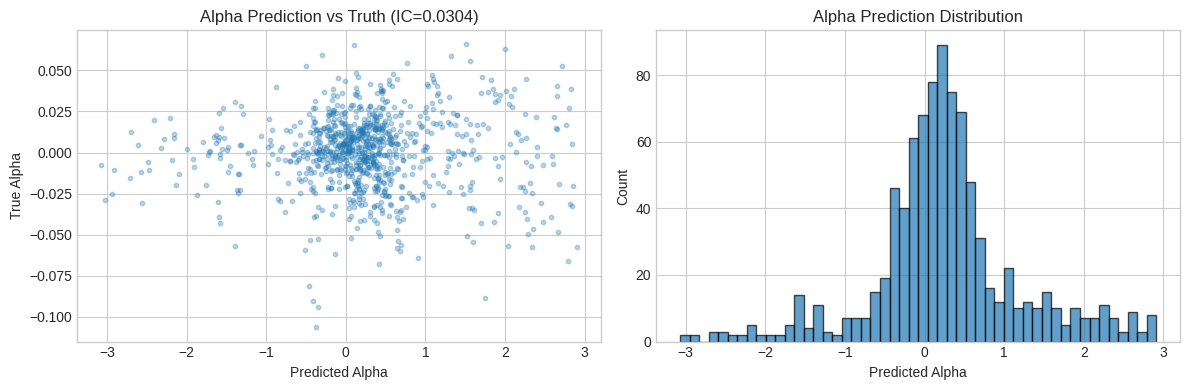

In [ ]:
# ========== Alpha model ==========

def compute_ic(pred, target):
    """ Information Coefficient (Pearson correlation)"""
    if len(pred) < 2:
        return 0.0
    return np.corrcoef(pred.flatten(), target.flatten())[0, 1]

# ： Alpha  IC
y_true = df_val_long['target_alpha'].values

#
min_len = min(len(alpha_pred), len(y_true))
alpha_pred_eval = alpha_pred[:min_len]
y_true_eval = y_true[:min_len]

#  IC
alpha_ic = compute_ic(alpha_pred_eval, y_true_eval)

print('=' * 60)
print('Alpha Transformer  (5CV + IC Loss)')
print('=' * 60)
print(f'validation set IC: {alpha_ic:.4f}')
print(f': {alpha_pred_eval.mean():.4f}')
print(f': {alpha_pred_eval.std():.4f}')

#
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(alpha_pred_eval, y_true_eval, alpha=0.3, s=10)
axes[0].set_xlabel('Predicted Alpha')
axes[0].set_ylabel('True Alpha')
axes[0].set_title(f'Alpha Prediction vs Truth (IC={alpha_ic:.4f})')

axes[1].hist(alpha_pred_eval, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Alpha')
axes[1].set_ylabel('Count')
axes[1].set_title('Alpha Prediction Distribution')

plt.tight_layout()
plt.show()

## 9. strategy：take profit + position

### Strategy logic
1. ****: Alpha >   Regime != Bear
2. **take profit**: return > 5% →  50%
3. **take profit**:  > 10 return →
4. ****: Alpha  →  50%
5. **stop loss**:  > 3% →

In [ ]:
"""
# ========== loadmodel (skip) ==========
import json
import os
import pickle
import lightgbm as lgb
import torch

MODEL_PATH_CANDIDATES = [
    "../content/drive/MyDrive/hull/models/",
    "/content/drive/MyDrive/hull/models/",
    "../models/",
]

MODEL_PATH = None
for p in MODEL_PATH_CANDIDATES:
    if os.path.exists(os.path.join(p, "transformer_config.json")):
        MODEL_PATH = p
        break

if MODEL_PATH is None:
    MODEL_PATH = MODEL_PATH_CANDIDATES[-1]

if 'device' not in globals():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ========== 1. load Transformer  ==========
with open(os.path.join(MODEL_PATH, 'transformer_config.json'), 'r') as f:
    trans_config = json.load(f)

transformer_features = trans_config['transformer_features']
N_TRANSFORMER_FEATURES = len(transformer_features)
SEQ_LEN = trans_config['seq_len']
MODEL_CONFIG = trans_config['model_config']
alpha_normalization = trans_config.get('alpha_normalization', {'mean': 0.0, 'std': 1.0})
TIME_WEIGHT_CONFIG = trans_config.get('time_weight_config', {})

# ========== 2. load Scaler ==========
with open(os.path.join(MODEL_PATH, 'scaler_alpha.pkl'), 'rb') as f:
    scaler = pickle.load(f)

# ========== 3. load Transformer model ==========
model = AlphaTransformer(**MODEL_CONFIG).to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'alpha_transformer.pt'), map_location=device))
model.eval()

# ========== 4. load LightGBM model ==========
lgbm_config_path = None
for fname in ('lgbm_config.json', 'lgbm_features.json'):
    p = os.path.join(MODEL_PATH, fname)
    if os.path.exists(p):
        lgbm_config_path = p
        break

if lgbm_config_path is None:
    raise FileNotFoundError(f'Cannot find lgbm_config.json or lgbm_features.json under MODEL_PATH={MODEL_PATH}')

with open(lgbm_config_path, 'r') as f:
    lgbm_config = json.load(f)

risk_features_long = lgbm_config.get('risk_features_long', lgbm_config.get('risk_features', []))
risk_features_short = lgbm_config.get('risk_features_short', risk_features_long)
regime_features_long = lgbm_config.get('regime_features_long', lgbm_config.get('regime_features', []))
regime_features_short = lgbm_config.get('regime_features_short', regime_features_long)

risk_features = risk_features_long
regime_features = regime_features_long

risk_model_long_path = os.path.join(MODEL_PATH, 'risk_model_long.txt')
if not os.path.exists(risk_model_long_path):
    risk_model_long_path = os.path.join(MODEL_PATH, 'risk_model.txt')

risk_model_short_path = os.path.join(MODEL_PATH, 'risk_model_short.txt')
if not os.path.exists(risk_model_short_path):
    risk_model_short_path = risk_model_long_path

regime_model_long_path = os.path.join(MODEL_PATH, 'regime_model_long.txt')
if not os.path.exists(regime_model_long_path):
    regime_model_long_path = os.path.join(MODEL_PATH, 'regime_model.txt')

regime_model_short_path = os.path.join(MODEL_PATH, 'regime_model_short.txt')
if not os.path.exists(regime_model_short_path):
    regime_model_short_path = regime_model_long_path

risk_model_long = lgb.Booster(model_file=risk_model_long_path)
risk_model_short = lgb.Booster(model_file=risk_model_short_path)
regime_model_long = lgb.Booster(model_file=regime_model_long_path)
regime_model_short = lgb.Booster(model_file=regime_model_short_path)

risk_model = risk_model_long
regime_model = regime_model_long

print('✓ modelload (model + Sigmoid time decay)')
"""
print('load，')


load，


In [ ]:
class TrendFollowingStrategy:
    """
    strategy V2.1 (: Core  Alpha)

    :
    A. Trailing Stop take profit -
    B. Alpha Hysteresis + EMA  -
    C. Core + Tactical position -
       ★ : Core position， Alpha

    position:
    - Core position:  Regime ， Bear
    - Tactical position:  Alpha ， alpha >
    - Total = (Core + Tactical) * Vol_Scale
    """

    # ========== A: Trailing Stop  ==========
    TRAILING_STOP_ATR_MULT = 2.5
    TRAILING_STOP_ATR_MULT_BULL = 3.5
    BREAKEVEN_TRIGGER = 0.025         # : 2.5%
    STOP_LOSS_PCT = 0.03

    # ========== B: Alpha Hysteresis  ==========
    ALPHA_OPEN_THRESHOLD = 0.1        # ★ : 0.3 -> 0.1 ( tactical)
    ALPHA_CLOSE_THRESHOLD = -0.2      # ★ : -0.3 -> -0.2
    ALPHA_EMA_SPAN = 5
    EXIT_CONFIRM_DAYS = 2

    # ========== C: Core + Tactical position ==========
    # Core position (, ) - ★  Alpha
    CORE_BASE = 0.4                   # Bull
    CORE_BEAR = 0.0                   # Bear
    CORE_NEUTRAL = 0.25               # ★ :

    # Tactical position (,  Alpha)
    TACTICAL_SCALE = 0.5
    TACTICAL_MAX = 1.2

    # position
    MAX_POSITION = 2.0
    MAX_POSITION_BULL = 2.0
    MAX_POSITION_BEAR = 0.5

    # ========== volatility ==========
    VOL_LOOKBACK = 20
    VOL_TARGET = 0.01
    VOL_SCALE_MIN = 0.3
    VOL_SCALE_MAX = 1.8
    VOL_TARGET_BULL = 0.011

    # ========== Regime  ==========
    BULL_PROB_THRESHOLD = 0.50        # ★ : 0.55 -> 0.50
    BEAR_PROB_THRESHOLD = 0.55

    # ==========  ==========
    MAX_HOLDING_DAYS_NEUTRAL = 30
    MAX_HOLDING_DAYS_BEAR = 15

    def __init__(self):
        self.reset()

    def reset(self):
        self.entry_price = None
        self.peak_price = None
        self.holding_days = 0
        self.current_position = 0.0
        self.core_position = 0.0
        self.tactical_position = 0.0
        self.peak_alpha = 0.0
        self.alpha_history = []
        self.returns_history = []
        self.exit_signal_days = 0
        self.trade_log = []
        self.breakeven_activated = False

    def _calc_alpha_ema(self, alpha):
        """ Alpha  EMA """
        self.alpha_history.append(alpha)
        if len(self.alpha_history) > self.ALPHA_EMA_SPAN * 2:
            self.alpha_history = self.alpha_history[-self.ALPHA_EMA_SPAN * 2:]

        if len(self.alpha_history) < 2:
            return alpha

        alpha_factor = 2.0 / (self.ALPHA_EMA_SPAN + 1)
        ema = self.alpha_history[0]
        for a in self.alpha_history[1:]:
            ema = alpha_factor * a + (1 - alpha_factor) * ema
        return ema

    def _calc_vol_scale(self, is_bull=False):
        """volatility"""
        if len(self.returns_history) < self.VOL_LOOKBACK:
            return 1.0

        recent_returns = np.array(self.returns_history[-self.VOL_LOOKBACK:])
        rolling_vol = np.std(recent_returns)

        if rolling_vol < 1e-8:
            return 1.0

        target = self.VOL_TARGET_BULL if is_bull else self.VOL_TARGET
        scale = target / rolling_vol
        return np.clip(scale, self.VOL_SCALE_MIN, self.VOL_SCALE_MAX)

    def _calc_trailing_stop(self, is_bull, rolling_vol):
        """ Trailing Stop """
        if self.peak_price is None or self.entry_price is None:
            return None

        atr_mult = self.TRAILING_STOP_ATR_MULT_BULL if is_bull else self.TRAILING_STOP_ATR_MULT
        atr = rolling_vol * self.peak_price if rolling_vol > 0 else self.peak_price * 0.01

        trailing_stop = self.peak_price - atr_mult * atr
        return trailing_stop

    def _calc_core_position(self, bull_prob, bear_prob):
        """ Core position ( Regime)"""
        is_bull = bull_prob > self.BULL_PROB_THRESHOLD
        is_bear = bear_prob > self.BEAR_PROB_THRESHOLD

        if is_bull:
            return self.CORE_BASE
        elif is_bear:
            return self.CORE_BEAR
        else:
            regime_score = bull_prob - bear_prob
            return self.CORE_NEUTRAL + regime_score * 0.15

    def _calc_tactical_position(self, alpha_ema):
        """ Tactical position ( Alpha)"""
        if alpha_ema <= 0:
            return 0.0

        tactical = alpha_ema * self.TACTICAL_SCALE
        return np.clip(tactical, 0, self.TACTICAL_MAX)

    def update(self, alpha, risk, bull_prob, bear_prob, current_price, date_id, daily_return=None):
        """
        strategyposition

        ★ : Core position Alpha， Bear
        """
        # return
        if daily_return is not None:
            self.returns_history.append(daily_return)
            if len(self.returns_history) > self.VOL_LOOKBACK * 2:
                self.returns_history = self.returns_history[-self.VOL_LOOKBACK * 2:]

        #  Regime
        is_bull = bull_prob > self.BULL_PROB_THRESHOLD
        is_bear = bear_prob > self.BEAR_PROB_THRESHOLD

        #  Alpha EMA
        alpha_ema = self._calc_alpha_ema(alpha)

        # volatility
        vol_scale = self._calc_vol_scale(is_bull)

        # Risk modelvolatility
        vol_scale_risk = 1.0
        try:
            if risk is not None:
                pred_annual_vol = float(np.exp(risk))
                target_annual_vol = float(self.VOL_TARGET * np.sqrt(252))
                if pred_annual_vol > 1e-8:
                    vol_scale_risk = np.clip(target_annual_vol / pred_annual_vol,
                                             self.VOL_SCALE_MIN, self.VOL_SCALE_MAX)
        except:
            vol_scale_risk = 1.0

        vol_scale = np.clip(vol_scale * vol_scale_risk, self.VOL_SCALE_MIN, self.VOL_SCALE_MAX)

        # volatility
        rolling_vol = np.std(self.returns_history[-self.VOL_LOOKBACK:]) if len(self.returns_history) >= self.VOL_LOOKBACK else 0.01

        # position
        if is_bull:
            max_pos = self.MAX_POSITION_BULL
        elif is_bear:
            max_pos = self.MAX_POSITION_BEAR
        else:
            max_pos = self.MAX_POSITION

        # ★★★ : Core position， ★★★
        new_core = self._calc_core_position(bull_prob, bear_prob)

        # ==========  ==========
        if self.current_position == 0:
            # ★ :  Core > 0  alpha ，
            should_open = (new_core > 0) or (alpha_ema > self.ALPHA_OPEN_THRESHOLD)

            if should_open:
                self.core_position = new_core
                # Tactical position alpha >
                if alpha_ema > self.ALPHA_OPEN_THRESHOLD:
                    self.tactical_position = self._calc_tactical_position(alpha_ema)
                else:
                    self.tactical_position = 0.0

                raw_position = self.core_position + self.tactical_position
                scaled_position = raw_position * vol_scale
                self.current_position = np.clip(scaled_position, 0, max_pos)

                if self.current_position > 0:
                    self.entry_price = current_price
                    self.peak_price = current_price
                    self.holding_days = 0
                    self.peak_alpha = alpha_ema
                    self.exit_signal_days = 0
                    self.breakeven_activated = False

                    self.trade_log.append({
                        'date_id': date_id, 'action': 'OPEN',
                        'position': self.current_position,
                        'core': self.core_position, 'tactical': self.tactical_position,
                        'alpha': alpha, 'alpha_ema': alpha_ema,
                        'vol_scale': vol_scale, 'price': current_price
                    })

            return self.current_position

        # ==========  ==========
        self.holding_days += 1
        self.peak_alpha = max(self.peak_alpha, alpha_ema)
        self.peak_price = max(self.peak_price, current_price)

        pnl_pct = (current_price - self.entry_price) / self.entry_price if self.entry_price else 0

        # stop loss
        if pnl_pct > self.BREAKEVEN_TRIGGER and not self.breakeven_activated:
            self.breakeven_activated = True
            self.trade_log.append({
                'date_id': date_id, 'action': 'BREAKEVEN_ACTIVATED',
                'pnl': pnl_pct, 'price': current_price
            })

        # ========== stop loss ==========
        # 1. stop loss
        if pnl_pct < -self.STOP_LOSS_PCT:
            self._close_position(date_id, current_price, 'STOP_LOSS', alpha_ema, vol_scale)
            return 0.0

        # 2. stop loss
        if self.breakeven_activated and pnl_pct < 0.005:
            self._close_position(date_id, current_price, 'BREAKEVEN_STOP', alpha_ema, vol_scale)
            return 0.0

        # 3. Trailing Stop
        trailing_stop = self._calc_trailing_stop(is_bull, rolling_vol)
        if trailing_stop is not None and current_price < trailing_stop:
            self._close_position(date_id, current_price, 'TRAILING_STOP', alpha_ema, vol_scale)
            return 0.0

        # ========== take profit ( Bear) ==========
        # ★ : Neutral take profit， Bear
        if is_bear and self.holding_days > self.MAX_HOLDING_DAYS_BEAR and pnl_pct < 0.01:
            self._close_position(date_id, current_price, 'TIME_EXIT', alpha_ema, vol_scale)
            return 0.0

        # ========== Alpha  () ==========
        if alpha_ema < self.ALPHA_CLOSE_THRESHOLD:
            self.exit_signal_days += 1
            if self.exit_signal_days >= self.EXIT_CONFIRM_DAYS:
                # ★ :  tactical， core
                if new_core > 0:
                    self.tactical_position = 0
                    self.core_position = new_core
                    self.current_position = np.clip(self.core_position * vol_scale, 0, max_pos)
                    self.trade_log.append({
                        'date_id': date_id, 'action': 'TACTICAL_EXIT',
                        'position': self.current_position, 'alpha_ema': alpha_ema
                    })
                else:
                    self._close_position(date_id, current_price, 'SIGNAL_EXIT', alpha_ema, vol_scale)
                    return 0.0
        else:
            self.exit_signal_days = 0

        # ========== position ==========
        self.core_position = new_core
        if alpha_ema > 0:
            self.tactical_position = self._calc_tactical_position(alpha_ema)
        else:
            self.tactical_position = 0

        raw_position = self.core_position + self.tactical_position
        scaled_position = raw_position * vol_scale
        self.current_position = np.clip(scaled_position, 0, max_pos)

        return self.current_position

    def _close_position(self, date_id, price, reason, alpha, vol_scale):
        self.trade_log.append({
            'date_id': date_id, 'action': reason,
            'position': 0, 'alpha': alpha, 'vol_scale': vol_scale, 'price': price,
            'holding_days': self.holding_days
        })
        self.current_position = 0.0
        self.core_position = 0.0
        self.tactical_position = 0.0
        self.entry_price = None
        self.peak_price = None
        self.holding_days = 0
        self.peak_alpha = 0.0
        self.exit_signal_days = 0
        self.breakeven_activated = False

    def get_trade_log(self):
        return pd.DataFrame(self.trade_log)


#
DynamicTakeProfitStrategy = TrendFollowingStrategy

print("✓ TrendFollowingStrategy V2.1  (Core  Alpha)")
print("  ★ : Core position Alpha ， Regime  Bear ")
print(f"  : ALPHA_OPEN={TrendFollowingStrategy.ALPHA_OPEN_THRESHOLD} ()")
print(f"  Bull : BULL_PROB={TrendFollowingStrategy.BULL_PROB_THRESHOLD} ()")
print(f"  Core : Bull={TrendFollowingStrategy.CORE_BASE}, Neutral={TrendFollowingStrategy.CORE_NEUTRAL}")

✓ TrendFollowingStrategy V2.1  (Core  Alpha)
  ★ : Core position Alpha ， Regime  Bear 
  : ALPHA_OPEN=0.1 ()
  Bull : BULL_PROB=0.5 ()
  Core : Bull=0.4, Neutral=0.25


### 9.1 strategy

In [ ]:
# ========== validation setstrategy (V2: +) ==========
strategy = TrendFollowingStrategy()

#  long period validation set
df_backtest = df_val_long.copy()
n_samples = len(df_backtest)

# Alpha
n_alpha = min(len(alpha_pred), n_samples)
alpha_pred_bt = np.zeros(n_samples)
alpha_pred_bt[:n_alpha] = alpha_pred[:n_alpha]

# Risk :  long  short
risk_pred_bt = risk_pred_long.copy()
n_short = len(risk_pred_short)
short_start_idx = n_samples - n_short
if short_start_idx >= 0 and short_start_idx < n_samples:
    risk_pred_bt[short_start_idx:] = (
        W_RISK_LONG * risk_pred_long[short_start_idx:] +
        (1 - W_RISK_LONG) * risk_pred_short
    )

# Regime :
regime_proba_bt = regime_proba_long.copy()
if short_start_idx >= 0 and short_start_idx < n_samples:
    regime_proba_bt[short_start_idx:] = (
        W_REGIME_LONG * regime_proba_long[short_start_idx:] +
        (1 - W_REGIME_LONG) * regime_proba_short
    )

bull_prob_bt = regime_proba_bt[:, 2]
bear_prob_bt = regime_proba_bt[:, 0]

#
final_len = min(n_alpha, n_samples)
alpha_pred_bt = alpha_pred_bt[:final_len]
risk_pred_bt = risk_pred_bt[:final_len]
bull_prob_bt = bull_prob_bt[:final_len]
bear_prob_bt = bear_prob_bt[:final_len]
df_backtest = df_backtest.iloc[:final_len]

print(f": {final_len}")
print(f"Short period : {short_start_idx}")

# return (volatility)
market_returns = df_backtest['market_forward_excess_returns'].values

#  proxy
cumulative_returns = (1 + market_returns).cumprod()
price_proxy = cumulative_returns

#
positions = []
core_positions = []
tactical_positions = []

for i in range(final_len):
    daily_ret = market_returns[i-1] if i > 0 else 0.0

    pos = strategy.update(
        alpha=alpha_pred_bt[i],
        risk=risk_pred_bt[i],
        bull_prob=bull_prob_bt[i],
        bear_prob=bear_prob_bt[i],
        current_price=price_proxy[i],
        date_id=df_backtest['date_id'].iloc[i],
        daily_return=daily_ret
    )
    positions.append(pos)
    core_positions.append(strategy.core_position)
    tactical_positions.append(strategy.tactical_position)

positions = np.array(positions)
core_positions = np.array(core_positions)
tactical_positions = np.array(tactical_positions)

# strategyreturn
strategy_returns = positions * market_returns

# return
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_market = (1 + market_returns).cumprod()

#  Sharpe
sharpe_strategy = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std() > 0 else 0
sharpe_market = market_returns.mean() / market_returns.std() * np.sqrt(252) if market_returns.std() > 0 else 0

#
def calc_max_drawdown(cumulative):
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_dd_strategy = calc_max_drawdown(cumulative_strategy)
max_dd_market = calc_max_drawdown(cumulative_market)

#
trade_log = strategy.get_trade_log()
n_trades = len(trade_log[trade_log['action'] == 'OPEN']) if len(trade_log) > 0 else 0

print('=' * 60)
print('validation set (V2: Trailing Stop + Hysteresis + Core/Tactical)')
print('=' * 60)
print(f'strategyreturn: {cumulative_strategy[-1] - 1:.2%}')
print(f'return: {cumulative_market[-1] - 1:.2%}')
print(f'return: {(cumulative_strategy[-1] - cumulative_market[-1]):.2%}')
print(f'strategy Sharpe: {sharpe_strategy:.4f}')
print(f' Sharpe: {sharpe_market:.4f}')
print(f'strategy: {max_dd_strategy:.2%}')
print(f': {max_dd_market:.2%}')
print(f'position: {positions.mean():.2%}')
print(f' Core position: {core_positions.mean():.2%}')
print(f' Tactical position: {tactical_positions.mean():.2%}')
print(f': {n_trades}')

#
if len(trade_log) > 0:
    print('\n:')
    action_counts = trade_log['action'].value_counts()
    for action, count in action_counts.items():
        print(f'  {action}: {count}')

: 901
Short period : 551
validation set (V2: Trailing Stop + Hysteresis + Core/Tactical)
strategyreturn: 105.49%
return: -1.23%
return: 106.72%
strategy Sharpe: 2.1307
 Sharpe: 0.0626
strategy: -8.35%
: -29.44%
position: 54.61%
 Core position: 23.52%
 Tactical position: 19.51%
: 69

:
  TACTICAL_EXIT: 142
  OPEN: 69
  TRAILING_STOP: 50
  BREAKEVEN_ACTIVATED: 34
  BREAKEVEN_STOP: 10
  STOP_LOSS: 7


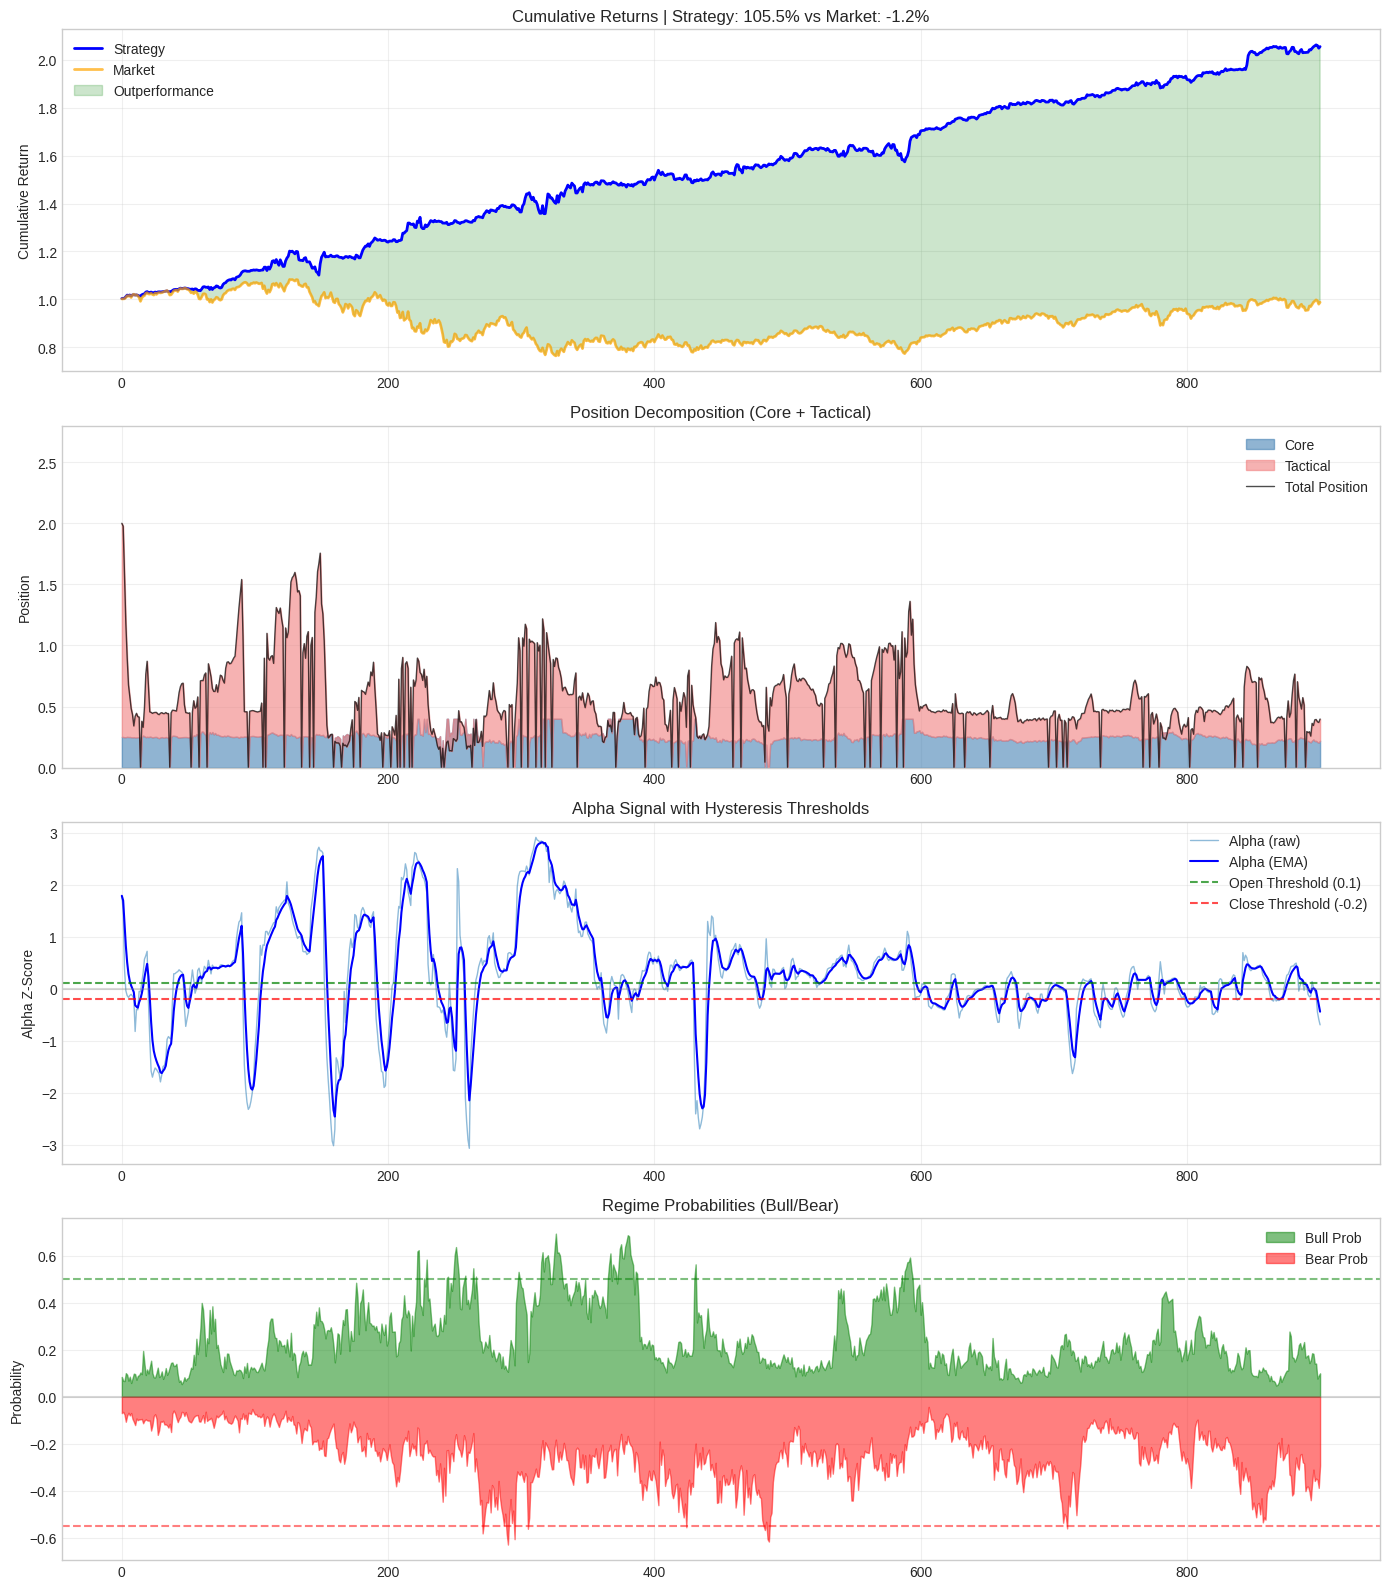


:
  : 901
  : 833 (92.5%)
  position (>1.5): 12
  Core : 0.24, Tactical : 0.20


In [ ]:
# ==========  (V2: Core + Tactical) ==========
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# 1. return
axes[0].plot(cumulative_strategy, label='Strategy', linewidth=2, color='blue')
axes[0].plot(cumulative_market, label='Market', linewidth=2, alpha=0.7, color='orange')
axes[0].fill_between(range(len(cumulative_strategy)),
                     cumulative_strategy, cumulative_market,
                     where=cumulative_strategy > cumulative_market,
                     alpha=0.2, color='green', label='Outperformance')
axes[0].fill_between(range(len(cumulative_strategy)),
                     cumulative_strategy, cumulative_market,
                     where=cumulative_strategy <= cumulative_market,
                     alpha=0.2, color='red')
axes[0].set_title(f'Cumulative Returns | Strategy: {cumulative_strategy[-1]-1:.1%} vs Market: {cumulative_market[-1]-1:.1%}', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True, alpha=0.3)

# 2. position (Core + Tactical)
axes[1].fill_between(range(len(positions)), core_positions, alpha=0.6, label='Core', color='steelblue')
axes[1].fill_between(range(len(positions)), core_positions, positions, alpha=0.6, label='Tactical', color='lightcoral')
axes[1].plot(positions, label='Total Position', linewidth=1, color='black', alpha=0.7)
axes[1].set_title('Position Decomposition (Core + Tactical)', fontsize=12)
axes[1].set_ylabel('Position')
axes[1].set_ylim(0, 2.8)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3. Alpha  +
axes[2].plot(alpha_pred_bt, label='Alpha (raw)', alpha=0.5, linewidth=1)
#  Alpha EMA
alpha_ema_vis = []
ema = alpha_pred_bt[0]
alpha_factor = 2.0 / (TrendFollowingStrategy.ALPHA_EMA_SPAN + 1)
for a in alpha_pred_bt:
    ema = alpha_factor * a + (1 - alpha_factor) * ema
    alpha_ema_vis.append(ema)
axes[2].plot(alpha_ema_vis, label='Alpha (EMA)', linewidth=1.5, color='blue')
axes[2].axhline(y=TrendFollowingStrategy.ALPHA_OPEN_THRESHOLD, color='green', linestyle='--',
                alpha=0.7, label=f'Open Threshold ({TrendFollowingStrategy.ALPHA_OPEN_THRESHOLD})')
axes[2].axhline(y=TrendFollowingStrategy.ALPHA_CLOSE_THRESHOLD, color='red', linestyle='--',
                alpha=0.7, label=f'Close Threshold ({TrendFollowingStrategy.ALPHA_CLOSE_THRESHOLD})')
axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[2].set_title('Alpha Signal with Hysteresis Thresholds', fontsize=12)
axes[2].set_ylabel('Alpha Z-Score')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# 4. Regime
axes[3].fill_between(range(len(bull_prob_bt)), bull_prob_bt, alpha=0.5, label='Bull Prob', color='green')
axes[3].fill_between(range(len(bear_prob_bt)), -bear_prob_bt, alpha=0.5, label='Bear Prob', color='red')
axes[3].axhline(y=TrendFollowingStrategy.BULL_PROB_THRESHOLD, color='green', linestyle='--', alpha=0.5)
axes[3].axhline(y=-TrendFollowingStrategy.BEAR_PROB_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[3].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[3].set_title('Regime Probabilities (Bull/Bear)', fontsize=12)
axes[3].set_ylabel('Probability')
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#
print(f'\n:')
print(f'  : {len(positions)}')
print(f'  : {(positions > 0).sum()} ({(positions > 0).mean()*100:.1f}%)')
print(f'  position (>1.5): {(positions > 1.5).sum()}')
print(f'  Core : {core_positions.mean():.2f}, Tactical : {tactical_positions.mean():.2f}')

In [ ]:
class AlphaTransformerInference:
    """
    Alpha Transformer  ()
    """

    def __init__(
        self,
        model,
        scaler,
        risk_model_long, risk_model_short,
        regime_model_long, regime_model_short,
        transformer_features,
        risk_features_long, risk_features_short,
        regime_features_long, regime_features_short,
        fusion_weights,
        alpha_normalization,
        seq_len=30, device='cpu'
    ):
        self.model = model
        self.scaler = scaler
        self.risk_model_long = risk_model_long
        self.risk_model_short = risk_model_short
        self.regime_model_long = regime_model_long
        self.regime_model_short = regime_model_short

        self.transformer_features = transformer_features
        self.risk_features_long = risk_features_long
        self.risk_features_short = risk_features_short
        self.regime_features_long = regime_features_long
        self.regime_features_short = regime_features_short

        self.w_risk_long = fusion_weights.get('w_risk_long', 0.5)
        self.w_regime_long = fusion_weights.get('w_regime_long', 0.5)

        self.seq_len = seq_len
        self.device = device
        self.alpha_mean = alpha_normalization['mean']
        self.alpha_std = alpha_normalization['std']

        self.history_df = None
        self.strategy = DynamicTakeProfitStrategy()
        self.model.eval()

    def initialize_history(self, train_df_tail):
        self.history_df = train_df_tail.copy()
        print(f'✓ : {len(self.history_df)} ')

    def predict(self, test_row_df):
        test_row_df = test_row_df.copy()

        if 'lagged_risk_free_rate' in test_row_df.columns and 'risk_free_rate' not in test_row_df.columns:
            test_row_df['risk_free_rate'] = test_row_df['lagged_risk_free_rate']
        if 'lagged_forward_returns' in test_row_df.columns and 'forward_returns' not in test_row_df.columns:
            test_row_df['forward_returns'] = test_row_df['lagged_forward_returns']
        if 'lagged_market_forward_excess_returns' in test_row_df.columns and 'market_forward_excess_returns' not in test_row_df.columns:
            test_row_df['market_forward_excess_returns'] = test_row_df['lagged_market_forward_excess_returns']

        daily_return = None
        try:
            if 'lagged_market_forward_excess_returns' in test_row_df.columns:
                v = test_row_df['lagged_market_forward_excess_returns'].values[0]
                if not pd.isna(v):
                    daily_return = float(v)
        except:
            daily_return = None

        self.history_df = pd.concat([self.history_df, test_row_df], ignore_index=True)

        max_history = self.seq_len + 50
        if len(self.history_df) > max_history:
            self.history_df = self.history_df.iloc[-max_history:]

        if len(self.history_df) < self.seq_len:
            return 0.0

        current_row = self.history_df.iloc[[-1]]
        seq_data = self.history_df[self.transformer_features].iloc[-self.seq_len:].values
        seq_scaled = self.scaler.transform(seq_data)

        # Transformer Alpha
        with torch.no_grad():
            seq_tensor = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0).to(self.device)
            alpha_pred = self.model(seq_tensor).cpu().item()

        # Risk ()
        risk_long = self.risk_model_long.predict(current_row[self.risk_features_long].values)[0]
        try:
            risk_short = self.risk_model_short.predict(current_row[self.risk_features_short].values)[0]
            risk_pred = self.w_risk_long * risk_long + (1 - self.w_risk_long) * risk_short
        except:
            risk_pred = risk_long

        # Regime ()
        regime_long = self.regime_model_long.predict(current_row[self.regime_features_long].values)[0]
        try:
            regime_short = self.regime_model_short.predict(current_row[self.regime_features_short].values)[0]
            regime_pred = self.w_regime_long * regime_long + (1 - self.w_regime_long) * regime_short
        except:
            regime_pred = regime_long

        bull_prob = regime_pred[2] if len(regime_pred) > 2 else 0.5
        bear_prob = regime_pred[0] if len(regime_pred) > 0 else 0.5

        date_id = current_row['date_id'].values[0] if 'date_id' in current_row.columns else 0
        price = 1.0

        position = self.strategy.update(
            alpha=alpha_pred,
            risk=risk_pred,
            bull_prob=bull_prob,
            bear_prob=bear_prob,
            current_price=price,
            date_id=date_id,
            daily_return=daily_return
        )

        return position

In [ ]:
# ==========  () ==========
inference = AlphaTransformerInference(
    model=model,
    scaler=scaler,
    risk_model_long=risk_model_long,
    risk_model_short=risk_model_short,
    regime_model_long=regime_model_long,
    regime_model_short=regime_model_short,
    transformer_features=transformer_features,
    risk_features_long=risk_features_long,
    risk_features_short=risk_features_short,
    regime_features_long=regime_features_long,
    regime_features_short=regime_features_short,
    fusion_weights={
        'w_risk_long': W_RISK_LONG,
        'w_regime_long': W_REGIME_LONG
    },
    alpha_normalization=alpha_normalization,
    seq_len=SEQ_LEN,
    device=device
)

# train set
inference.initialize_history(df_train.iloc[-60:])

print('✓  ()')
print(f'  weights: Risk Long={W_RISK_LONG:.2f}, Regime Long={W_REGIME_LONG:.2f}')
print(f'  Alpha standardization: mean={alpha_normalization["mean"]:.6f}, std={alpha_normalization["std"]:.6f}')

✓ : 60 
✓  ()
  weights: Risk Long=0.62, Regime Long=0.78
  Alpha standardization: mean=0.000764, std=0.023305


In [ ]:
# ==========  () ==========
inference = AlphaTransformerInference(
    model=model,
    scaler=scaler,
    risk_model_long=risk_model_long,
    risk_model_short=risk_model_short,
    regime_model_long=regime_model_long,
    regime_model_short=regime_model_short,
    transformer_features=transformer_features,
    risk_features_long=risk_features_long,
    risk_features_short=risk_features_short,
    regime_features_long=regime_features_long,
    regime_features_short=regime_features_short,
    fusion_weights={
        'w_risk_long': W_RISK_LONG,
        'w_regime_long': W_REGIME_LONG
    },
    alpha_normalization=alpha_normalization,
    seq_len=SEQ_LEN,
    device=device
)

# train set
inference.initialize_history(df_train.iloc[-60:])

print('✓  ()')
print(f'  weights: Risk Long={W_RISK_LONG:.2f}, Regime Long={W_REGIME_LONG:.2f}')
print(f'  Alpha standardization: mean={alpha_normalization["mean"]:.6f}, std={alpha_normalization["std"]:.6f}')

✓ : 60 
✓  ()
  weights: Risk Long=0.62, Regime Long=0.78
  Alpha standardization: mean=0.000764, std=0.023305


In [ ]:
# ========== Kaggle  ==========
#  notebook

SUBMISSION_CODE = '''
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import pickle
import json
import os

# ========== load ==========
with open('/kaggle/input/hull-models/transformer_config.json', 'r') as f:
    trans_config = json.load(f)

lgbm_config_path = '/kaggle/input/hull-models/lgbm_config.json'
if not os.path.exists(lgbm_config_path):
    lgbm_config_path = '/kaggle/input/hull-models/lgbm_features.json'

with open(lgbm_config_path, 'r') as f:
    lgbm_config = json.load(f)

lgbm_features = []
try:
    if isinstance(lgbm_config, dict):
        lgbm_features = lgbm_config.get('alpha_features', lgbm_config.get('lgbm_features', []))
    else:
        lgbm_features = lgbm_config
except:
    lgbm_features = []

MODEL_CONFIG = trans_config['model_config']
transformer_features = trans_config['transformer_features']
SEQ_LEN = trans_config['seq_len']
alpha_normalization = trans_config['alpha_normalization']

# ========== model ==========
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class AlphaTransformer(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, n_layers=2, d_ff=128, dropout=0.1, max_len=100):
        super().__init__()
        self.input_projection = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze(-1)

# ========== loadmodel ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Alpha Transformer (model + Sigmoid time decay)
model = AlphaTransformer(**MODEL_CONFIG).to(device)
model.load_state_dict(torch.load('/kaggle/input/hull-models/alpha_transformer.pt', map_location=device))
model.eval()

# Scaler
with open('/kaggle/input/hull-models/scaler_alpha.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Risk & Regime LGBM
risk_model_path = '/kaggle/input/hull-models/risk_model_long.txt'
if not os.path.exists(risk_model_path):
    risk_model_path = '/kaggle/input/hull-models/risk_model.txt'

regime_model_path = '/kaggle/input/hull-models/regime_model_long.txt'
if not os.path.exists(regime_model_path):
    regime_model_path = '/kaggle/input/hull-models/regime_model.txt'

risk_model = lgb.Booster(model_file=risk_model_path)
regime_model = lgb.Booster(model_file=regime_model_path)

print("Models loaded successfully (Single model + Sigmoid time decay weighting)")
'''

print('Kaggle ')
print(' SUBMISSION_CODE  notebook ')


Kaggle 
 SUBMISSION_CODE  notebook 


## 12. save

In [34]:
# ========== save ==========

def _extract_class_params(cls, keys):
    params = {}
    for k in keys:
        if hasattr(cls, k):
            v = getattr(cls, k)
            try:
                import numpy as np
                if isinstance(v, (np.integer, np.floating)):
                    v = v.item()
            except Exception:
                pass
            params[k] = v
    return params


STRATEGY_PARAM_KEYS = [
    'TRAILING_STOP_ATR_MULT',
    'TRAILING_STOP_ATR_MULT_BULL',
    'BREAKEVEN_TRIGGER',
    'STOP_LOSS_PCT',
    'ALPHA_OPEN_THRESHOLD',
    'ALPHA_CLOSE_THRESHOLD',
    'ALPHA_EMA_SPAN',
    'EXIT_CONFIRM_DAYS',
    'CORE_BASE',
    'CORE_BEAR',
    'CORE_NEUTRAL',
    'TACTICAL_SCALE',
    'TACTICAL_MAX',
    'MAX_POSITION',
    'MAX_POSITION_BULL',
    'MAX_POSITION_BEAR',
    'VOL_LOOKBACK',
    'VOL_TARGET',
    'VOL_SCALE_MIN',
    'VOL_SCALE_MAX',
    'VOL_TARGET_BULL',
    'BULL_PROB_THRESHOLD',
    'BEAR_PROB_THRESHOLD',
    'MAX_HOLDING_DAYS_NEUTRAL',
    'MAX_HOLDING_DAYS_BEAR',
]

fusion_weights = {}
for _k, _out_k in [
    ('W_RISK_LONG', 'w_risk_long'),
    ('W_REGIME_LONG', 'w_regime_long'),
    ('W_RISK_SHORT', 'w_risk_short'),
    ('W_REGIME_SHORT', 'w_regime_short'),
]:
    _v = globals().get(_k)
    if _v is not None:
        fusion_weights[_out_k] = float(_v)

features = {
    'transformer_features': transformer_features,
}
for _name in [
    'risk_features_long',
    'risk_features_short',
    'regime_features_long',
    'regime_features_short',
]:
    _v = globals().get(_name)
    if _v is not None:
        features[_name] = _v

final_config = {
    'model': {
        'transformer': MODEL_CONFIG_OPTIMIZED,
        'seq_len': SEQ_LEN,
        'n_transformer_features': N_TRANSFORMER_FEATURES,
    },
    'time_weight_config': TIME_WEIGHT_CONFIG,
    'fusion_weights': fusion_weights,
    'strategy': {
        'class': 'TrendFollowingStrategy',
        'params': _extract_class_params(TrendFollowingStrategy, STRATEGY_PARAM_KEYS),
    },
    'alpha_normalization': alpha_normalization,
    'features': features,
}

with open(f'{MODEL_PATH}/final_config.json', 'w') as f:
    json.dump(final_config, f, indent=2)

print('✓ saved')
print(f'  - {MODEL_PATH}/final_config.json')
print(f"  - strategy params: {len(final_config['strategy']['params'])} keys")


✓ saved
  - ../content/drive/MyDrive/hull/models/final_config.json
  - strategy params: 25 keys


## 13.

### model
|  |  |
|------|------|
| `alpha_transformer.pt` | Alpha Transformer (2007-2025 + Sigmoid time decay) |
| `scaler_alpha.pkl` | StandardScaler |
| `risk_model.txt` | Risk LGBM |
| `regime_model.txt` | Regime LGBM |
| `transformer_config.json` | Transformer  |
| `lgbm_features.json` | LGBM features |
| `final_config.json` |  |

###
```
┌─────────────────────────────────────────────────────────────────┐
│                        INPUT DATA                               │
│                   (Past 30 days features)                       │
└─────────────────────┬───────────────────────────────────────────┘
                      │
                      ▼
┌─────────────────────────────────────────────────────────────────┐
│              Single Period Model (2007-2025)                    │
│           + Sigmoid Time Decay Weighting                        │
├─────────────────────────────────────────────────────────────────┤
│  • 2007-2017: old regime (weights ~0.3)                                │
│  • 2017-2019: smooth transition                                        │
│  • 2018-2025: new regime (weights ~1.0)                                │
├─────────────────────────────────────────────────────────────────┤
│  Alpha: Transformer (time decay Loss)                         │
│  Risk:  LightGBM                                                │
│  Regime: LightGBM                                               │
└─────────────────────────────────────────────────────────────────┘
                      │
                      ▼
            ┌─────────────────────┐
            │  Dynamic Strategy   │
            │  - Take Profit 5%   │
            │  - Stop Loss 3%     │
            │  - Time Exit 10d    │
            │  - Momentum Decay   │
            └─────────────────────┘
                      │
                      ▼
            ┌─────────────────────┐
            │   Final Position    │
            │      [0, 1]         │
            └─────────────────────┘
```

### time decay
1. ****: 2018-2025  Transformer
2. ****: ，
3. **smooth transition**: Sigmoid
4. ****:  steepness

In [36]:
print('=' * 70)
print('TRAINING COMPLETE')
print('=' * 70)

print('\n📊 model:')
print(f'  Transformer params: {sum(p.numel() for p in model.parameters()):,}')
print(f'  seq_len: {SEQ_LEN}')
print(f'  n_features: {N_TRANSFORMER_FEATURES}')

print('\n⏰ time decay:')
print(f'  breakpoint: {TIME_WEIGHT_CONFIG["breakpoint_year"]}')
print(f'  steepness: {TIME_WEIGHT_CONFIG["steepness"]}')
print(f'  weights: [{TIME_WEIGHT_CONFIG["min_weight"]}, {TIME_WEIGHT_CONFIG["max_weight"]}]')

print('\n🎯 strategy (TrendFollowingStrategy):')
print(f'  stop_loss_pct: {TrendFollowingStrategy.STOP_LOSS_PCT:.0%}')
print(f'  max_position: {TrendFollowingStrategy.MAX_POSITION:.2f}')
print(f'  max_holding_days_neutral: {TrendFollowingStrategy.MAX_HOLDING_DAYS_NEUTRAL}')
print(f'  max_holding_days_bear: {TrendFollowingStrategy.MAX_HOLDING_DAYS_BEAR}')

print('\n📁 saved artifacts:')
print('  ../models/alpha_transformer.pt')
print('  ../models/scaler_alpha.pkl')
print('  ../models/risk_model_long.txt')
print('  ../models/risk_model_short.txt')
print('  ../models/regime_model_long.txt')
print('  ../models/regime_model_short.txt')
print('  ../models/transformer_config.json')
print('  ../models/lgbm_config.json')
print('  ../models/final_config.json')

print('\n' + '=' * 70)
print('✓ Ready for Kaggle submission!')
print('=' * 70)


TRAINING COMPLETE

📊 model:
  Transformer params: 5,633
  seq_len: 10
  n_features: 64

⏰ time decay:
  breakpoint: 2018
  steepness: 2.0
  weights: [0.3, 1.0]

🎯 strategy (TrendFollowingStrategy):
  stop_loss_pct: 3%
  max_position: 2.00
  max_holding_days_neutral: 30
  max_holding_days_bear: 15

📁 saved artifacts:
  ../models/alpha_transformer.pt
  ../models/scaler_alpha.pkl
  ../models/risk_model_long.txt
  ../models/risk_model_short.txt
  ../models/regime_model_long.txt
  ../models/regime_model_short.txt
  ../models/transformer_config.json
  ../models/lgbm_config.json
  ../models/final_config.json

✓ Ready for Kaggle submission!
